<a id='top'></a>
# Milestone 3

<div class="alert alert-block alert-info">
<b>Information:</b> The <em>Imports and method definitions</em> section is at the begining of this notebook for running purposes. To better follow the flow of this project, we advise to start the reading at the <em>Research Question</em> section, see Table of content below
</div>

## Table of Content
_[Back to top](#top)_
1. [Imports and Methods Definitions](#imports-and-methods-definitions)
 1. [Loading and Cleaning Metadata](#metadata_methods)
 1. [File Conversions](#file_conversions_methods)
 1. [Loading Note Lists](#loading_note_lists_methods)
 1. [Loading MIDI Tracks Into Memory](#loading_tracks_into_memory_methods)
 1. [Extracting Extra Metadata](#extra_metadata_extraction_methods)
 1. [Data Presentation Methods](#data_presentation_methods)
 1. [Exploring Metadata](#exploring_metadata)
 1. [Exploring Note Lists](#exploring_note_lists)
***
1. [Research Question](#rq)
1. [Data Presentation](#data-presentation)
1. [Methods](#methods)
 1. [Keys and Movements Structure](#keys-and-movements)
 1. [Tutti VS Solo](#tutti-solo)
 1. [Rythmic and Pitch Patterns](#patterns)
1. [Results](#results)
 1. [Keys and movements analysis](#key_an)
 1. [Frequency of instruments playing analysis](#freq_an)
 1. [Repeating patterns analysis](#pattern_an)
1. [Conclusion](#conclusion)

<a id='imports-and-methods-definitions'></a>
## Imports and Methods Definitions
_[Back to top](#top)_

In [63]:
# Import utils functions, basic imports, constant definitions
#%run ./my_utils.ipynb
import ipynb.fs.full.my_utils as utils

import os
import pandas as pd
import re
import seaborn as sns

from functools import reduce
from music21.midi import MidiFile, MidiTrack as Track, MidiEvent as Event
from music21 import converter, note, meter, key, chord
from ms3 import convert as ms3convert, Parse
from shutil import rmtree

from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import itertools

from suffix_tree import Tree
import interval as Interval
from tqdm import tqdm

NaN = float('NaN')
MS = utils.get_mscore() # If using a mac and Musescore not obtained through brew, pass false, else don't touch this
corpus_root = 'data/'
midi_root = corpus_root + 'midi/'
ms_root = corpus_root + 'musescore/'

composers = ["Vivaldi", "Telemann", "Bach", "Corelli"]

<a id='metadata_methods'></a>
### Loading and cleaning metadata
_[Back to top](#top)_

In [64]:
# Helper methods to load and clean a metadata file

def load_metadata(filename='metadata.tsv'):
    path = corpus_root + filename
    if os.path.exists(path):
        df = pd.read_csv(path, delimiter='\t')
        df = utils.clean_columns(df, ["keys", "movements", "instruments"])
        df = df[df.composer.isin(composers)].reset_index(drop=True)
        df["track_ids"] = [[] for _ in df.index]
        df["type"] = df["work_title"].apply(utils.extract_from_regex)
        df["keys"] = [[row[0].replace("♭", "-flat").replace("#", '-sharp')] if row else [] for row in df["keys"]]
        #df["keys"] = df["keys"].apply(lambda row: str(row).replace("'", "").replace("]", "").replace("[", ""))
        return df
    else:
        return pd.DataFrame(columns=["id", "composer", "work_title", "keys", "nb_movements", 
                                     "movements", "instruments", "track_ids"])

# Updating metadata with index 
# TODO: rework this. Also maybe get additional metadata from the midis
def update_metadata(meta, filename, pos):
    composer, idx, part = filename.split('.')[0].split('_', 3)

    if part == "full":
        pid = part
        tot = NaN
    else:
        pid, tot = part.split('o')

    if idx in meta.id.values:
        row = meta.loc[meta.id == idx].iloc[0]
        ids = [pid for pid, _ in row["track_ids"]]
        if not pid in ids:
            meta.at[row.name, "track_ids"] = row["track_ids"].copy() + [(pid, pos)]
        else:
            return False, meta
    else:
        row = {"id":idx, "composer": composer.capitalize(), "keys":[],
               "nb_movements":tot, "track_ids": [(pid, pos)]}
        meta = meta.append(row, ignore_index=True)
    return True, meta

def index_loaded_tracks(meta, col='track_ids'):
    tmp = meta.explode(col).reset_index(drop=True).dropna(subset=[col])
    tmp2 = pd.DataFrame(tmp[col].tolist(), index=tmp.index, columns=["m_id", "track_id"])
    return pd.concat([tmp.iloc[:, :-1], tmp2], axis=1)

In [65]:
metadata = load_metadata()
metadata

id composer                                         work_title  \
0    RV497  Vivaldi                        Bassoon Concerto in A minor   
1    RV498  Vivaldi                        Bassoon Concerto in A minor   
2    RV499  Vivaldi                        Bassoon Concerto in A minor   
3    RV500  Vivaldi                        Bassoon Concerto in A minor   
4    RV501  Vivaldi                   Bassoon Concerto in B-flat major   
..     ...      ...                                                ...   
296    NaN  Corelli                         Concerto grosso in C minor   
297    NaN  Corelli                         Concerto grosso in D major   
298    NaN  Corelli  Concerto grosso No.8 'Fatto per la Notte di Na...   
299    NaN  Corelli                         Concerto grosso in C major   
300    NaN  Corelli                    Concerto grosso in B-flat major   

               keys nb_movements  \
0         [A minor]            3   
1         [A minor]            3   
2         [A minor]            3   
3         [A minor]            3   
4    [B-flat major]            5   
..              ...          ...   
296       [C minor]            5   
297       [D major]            4   
298       [G minor]            5   
299       [C major]            6   
300  [B-flat major]            6   

                                             movements  \
0              [Allegro molto, Andante molto, Allegro]   
1                        [Allegro, Larghetto, Allegro]   
2                            [Allegro, Largo, Allegro]   
3                            [Allegro, Largo, Allegro]   
4    [Largo - Andante molto, Presto (Fantasmi), Pre...   
..                                                 ...   
296  [Largo, Allegro – Adagio, Grave, Vivace, Allegro]   
297  [Adagio - Allegro, Adagio, Vivace, (Giga) Alle...   
298  [Vivace – GraveArcate, sostenuto e come stà, A...   
299  [Preludio: Largo, Allemanda: Allegro, Adagio, ...   
300  [Preludio: Largo, Allemanda: Allegro, Adagio, ...   

                                    instruments track_ids      type  
0                  [bassoon, strings, continuo]        []  Concerto  
1                  [bassoon, strings, continuo]        []  Concerto  
2                  [bassoon, strings, continuo]        []  Concerto  
3                  [bassoon, strings, continuo]        []  Concerto  
4                  [bassoon, strings, continuo]        []  Concerto  
..                                          ...       ...       ...  
296   [2 violin, cello soli, strings, continuo]        []  Concerto  
297  [2 violins, cello soli, strings, continuo]        []  Concerto  
298       [2 violins, cello, strings, continuo]        []  Concerto  
299  [2 violins, cello soli, strings, continuo]        []  Concerto  
300  [2 violins, cello soli, strings, continuo]        []  Concerto  

[301 rows x 9 columns]

In [66]:
# Add the ids for Corelli's concerti manually as the metadata scraper could not do it automatically 
corelli_ids = {"C1": "Concerto grosso in D major",
    "op6-8": "Concerto grosso No.8 'Fatto per la Notte di Natale'",
    "op6-9": "Concerto No.9 in F major",
    "op6-10": "Concerto grosso in C major",
    "op6-11": "Concerto grosso in B-flat major",
    "op6-2": "Concerto grosso in F major",
    "op6-3": "Concerto grosso in C minor",
    "op6-4": "Concerto grosso in D major",
    "op6-6": "Concerto grosso in F major",
    "op6-7": "Concerto grosso in D major"}

for ids, name in corelli_ids.items():
    index_row = metadata[metadata.work_title == name].index
    metadata.loc[index_row, "id"] = ids


<a id='file_conversions_methods'></a>
### File conversions
_[Back to top](#top)_

In [67]:
# Helpers for converting MIDI files to lists of nodes

# Checks if all reference (usually midi) tracks exist in target file format
# (exists because it's faster and less wordy than running a full conversion on 
# An already fully converted folder)
def check_tracks(ref_dir=midi_root, ref_extension=".mid", comp_dir=ms_root, comp_extension=".mscx"):
    for dir_ in os.listdir(midi_root):
        path = os.path.join(midi_root, dir_)
        comp_path = os.path.join(comp_dir, dir_)
        if not os.path.exists(comp_path):
            os.makedirs(comp_path)
        if (os.path.isdir(path)):
            for filename in os.listdir(path):
                name, ext = os.path.splitext(filename)
                if ext == ref_extension:
                    comp_filename = name + comp_extension
                    if comp_filename not in os.listdir(comp_path):
                        return True
    return False

# If tracks don't exist as Musescore files, convert them
def convert_tracks(midi_root=midi_root, ms_root=ms_root):
    missing = check_tracks()
    if missing:
        ms3convert.convert_folder(midi_root, ms_root, extensions=["mid"], MS=MS)
    return missing

# Converts MIDI files as tsv if necessary
# `delete_intermediate` deletes mscx files from disk after conversion because they are heavy!
# (like 60 times heavier than midi-heavy)
def tracks_to_tsv(midi_root=midi_root, ms_root=ms_root, delete_intermediate=True, 
                 features=["measures", "notes_and_rests"]):
    missing = False
    for feature in features:
        missing |= check_tracks(comp_dir=os.path.join(corpus_root,feature), comp_extension=".tsv")
    if missing:
        print("Running...")
        converted = convert_tracks(midi_root, ms_root)
        p = Parse(ms_root)
        p.parse_mscx()
        all_features = ["notes", "measures", "rests", "notes_and_rests", "events", "labels", "chords", "expanded"]
        list_dir = dict([(k, k if k in features else None) for k in all_features])
        p.store_lists(root_dir=corpus_root, notes_folder=list_dir["notes"], rests_folder=list_dir["rests"], 
                      notes_and_rests_folder=list_dir["notes_and_rests"], measures_folder=list_dir["measures"],
                      events_folder=list_dir["events"], labels_folder=list_dir["labels"], 
                      chords_folder=list_dir["chords"], expanded_folder=list_dir["expanded"])
        if converted and delete_intermediate:
            rmtree(ms_root)
    else:
        print("Nothing to be done")
    return missing

In [68]:
tracks_to_tsv()

Nothing to be done


False

<a id='loading_note_lists_methods'></a>
### Loading note lists
_[Back to top](#top)_

TODO: load multiple tracks at once! 

In [69]:
# Loads track as note list from the tsv files
def load_track_df(composer, idx, parts=None, folder="notes_and_rests", corpus_root=corpus_root, verbose=False):
    root = os.path.join(corpus_root, folder)
    if not os.path.exists(root):
        print(f"No folder with that name: {folder}")
        return None
    df_list = []
    loaded = []
    index = ["composer", "id", "part_id"]
    if parts:
        parts = list(map(str, parts))
    for dir_ in os.listdir(root):
        if composer in dir_:
            path = os.path.join(root, dir_)
            if (os.path.isdir(path)):
                for filename in os.listdir(path):
                    name, ext = os.path.splitext(filename)
                    comp, id_, part_ = name.split('_')
                    part = part_ if part_ == 'full' else part_.split('o')[0]
                    if ext == ".tsv" and (not idx or idx in filename):
                        if not parts or part in parts:
                            df = pd.read_csv(os.path.join(path, filename), sep='\t')
                            original_cols = df.columns
                            df["composer"] = comp
                            df["id"] = id_
                            df["part_id"] = part
                            df = df[index + original_cols.tolist()]
                            df_list.append(df)
                            loaded.append(part)
    
    if not loaded:
        if verbose:
            print(f"No files found for track {idx}.")
        return None
    missed = ""
    if parts:
        missing = [x for x in parts if x not in loaded]
        if missing and verbose:
            missed = f"No file found for parts {missing}"
    if verbose:
        print(f"Succesfully loaded parts {loaded} of track {idx}. {missed}")
    res_df = pd.concat(df_list, axis=0, ignore_index=True)
    return res_df.sort_values(by=index+['mc']).reset_index(drop=True)

def load_all_tracks_df(folder="notes_and_rests", corpus_root=corpus_root, composers=composers):
    df_list = []
    for composer in composers:
        df_list.append(load_track_df(composer.lower(), None, folder=folder, corpus_root=corpus_root, verbose=False))
    res_df = pd.concat(df_list, axis=0, ignore_index=True)
    res_df['midi'] = res_df['midi']
    return pd.concat(df_list, axis=0, ignore_index=True)

In [70]:
all_tracks = load_all_tracks_df()
all_tracks

composer     id part_id  mc  mn mc_onset mn_onset timesig  staff  \
0       vivaldi    RV1       1   1   1        0        0     3/4      4   
1       vivaldi    RV1       1   1   1        0        0     3/4      2   
2       vivaldi    RV1       1   1   1        0        0     3/4      2   
3       vivaldi    RV1       1   1   1        0        0     3/4      1   
4       vivaldi    RV1       1   1   1        0        0     3/4      2   
...         ...    ...     ...  ..  ..      ...      ...     ...    ...   
414262  corelli  op6-8       5  57  57        0        0    12/8      1   
414263  corelli  op6-8       5  57  57      3/8      3/8    12/8      1   
414264  corelli  op6-8       5  57  57      3/8      3/8    12/8      2   
414265  corelli  op6-8       5  57  57      3/4      3/4    12/8      1   
414266  corelli  op6-8       5  57  57      3/4      3/4    12/8      2   

        voice  ...  tpc  midi volta  chord_id  event  Chord/dots  \
0           1  ...  0.0  60.0   NaN       5.0    NaN         NaN   
1           1  ...  4.0  64.0   NaN       3.0    NaN         NaN   
2           1  ...  1.0  67.0   NaN       3.0    NaN         NaN   
3           1  ...  0.0  72.0   NaN       0.0    NaN         NaN   
4           1  ...  0.0  72.0   NaN       3.0    NaN         NaN   
...       ...  ...  ...   ...   ...       ...    ...         ...   
414262      1  ...  5.0  71.0   NaN     859.0    NaN         NaN   
414263      1  ...  NaN   NaN   NaN       NaN    NaN         NaN   
414264      1  ...  NaN   NaN   NaN       NaN    NaN         NaN   
414265      1  ...  NaN   NaN   NaN       NaN    NaN         NaN   
414266      1  ...  NaN   NaN   NaN       NaN    NaN         NaN   

        Chord/durationType  Tempo/tempo  Tempo/text  Tempo/text/sym  
0                      NaN          NaN         NaN             NaN  
1                      NaN          NaN         NaN             NaN  
2                      NaN          NaN         NaN             NaN  
3                      NaN          NaN         NaN             NaN  
4                      NaN          NaN         NaN             NaN  
...                    ...          ...         ...             ...  
414262                 NaN          NaN         NaN             NaN  
414263                 NaN          NaN         NaN             NaN  
414264                 NaN          NaN         NaN             NaN  
414265                 NaN          NaN         NaN             NaN  
414266                 NaN          NaN         NaN             NaN  

[414267 rows x 24 columns]

In [71]:
rv26_df = load_track_df('viv', 'RV26')

<a id='loading_tracks_into_memory_methods'></a>
### Loading tracks into memory 
_[Back to top](#top)_

TODO: do we need that if we have notes dfs? maybe for metadata. probably not worth keeping them in memory at least

In [72]:
# Loads a certain amount (max_iter) of the tracks in memory
def load_tracks(corpus_root=midi_root, converter=converter, metadata=metadata, track_list=[], max_iter=15):
    meta = metadata.copy()
    tracks = track_list.copy()
    pos = len(track_list)

    for dir_ in os.listdir(corpus_root):
        path = corpus_root + dir_
        if (os.path.isdir(path)):
            for filename in os.listdir(path):
                if ".mid" in filename:
                    new_track, meta = update_metadata(meta, filename, pos)
                        
                    if new_track:
                        track = converter.parse(os.path.join(path, filename))
                        tracks.append(track)
                        pos += 1
                    
                    if max_iter != None and pos >= max_iter+len(track_list):
                        return tracks, meta
    return tracks, meta

In [73]:
tracks, meta = load_tracks()
#tracks, meta = load_tracks(track_list=tracks, metadata=meta, max_iter=50)
tracks_indexer = index_loaded_tracks(meta)
meta[meta.track_ids.apply(len)>0]

id composer                       work_title            keys  \
260  BWV1046     Bach        Brandenburg Concerto No.1       [F major]   
261  BWV1047     Bach        Brandenburg Concerto No.2       [F major]   
299   op6-10  Corelli       Concerto grosso in C major       [C major]   
300   op6-11  Corelli  Concerto grosso in B-flat major  [B-flat major]   
301   BWV971     Bach                              NaN              []   

    nb_movements                                          movements  \
260            4  [[no tempo indication], (usually performed at ...   
261            3    [[no tempo indication], Andante, Allegro assai]   
299            6  [Preludio: Largo, Allemanda: Allegro, Adagio, ...   
300            6  [Preludio: Largo, Allemanda: Allegro, Adagio, ...   
301            3                                                NaN   

                                           instruments  \
260  [Concertante: 3 oboes, bassoon, 2 horns, violi...   
261  [recorder*, oboe, trumpet, violin, strings, co...   
299         [2 violins, cello soli, strings, continuo]   
300         [2 violins, cello soli, strings, continuo]   
301                                                NaN   

                                             track_ids      type  
260                           [(2, 0), (3, 1), (4, 2)]  Concerto  
261                           [(1, 3), (2, 4), (3, 5)]  Concerto  
299  [(1, 7), (2, 8), (3, 9), (4, 10), (5, 11), (6,...  Concerto  
300                                 [(1, 13), (2, 14)]  Concerto  
301                                           [(1, 6)]       NaN

In [74]:
# Gets the ids of all loaded tracks by a given composer
def composer_tracks_ids(composer, tracks_indexer=tracks_indexer):
    df = tracks_indexer[tracks_indexer.composer.str.contains(composer, case=False)]
    if "track_id" in tracks_indexer.columns:
        return df["track_id"].dropna().apply(int).tolist()
    elif "track_ids" in tracks_indexer.columns:
        res = []
        for l in df["track_ids"]:
            res += [int(v) for _, v in l]
        return res
    return []

<a id='extra_metadata_extraction_methods'></a>
### Extracting extra metadata from MIDI files
_[Back to top](#top)_

In [75]:
# Helpers for extracting some extra metadata from MIDI files
def get_instruments(track):
    res = []
    counter = []
    for part in track:
        name = utils.getOrElse(part.partName, utils.get_instrument(part))
        if name and name in res:
            n = res.index(name)
            if counter[n] == 0:
                counter[n]+=1
            counter.append(counter[n]+1)
        else:
            counter.append(0)
        res.append(name)
    for i, c in enumerate(counter):
        if c:
            res[i] += f" {c}"
    return res

def event_to_text(event):
    if isinstance(event, meter.TimeSignature):
        return event.ratioString
    elif isinstance(event, chord.Chord):
        return event.pitchNames
    elif isinstance(event, key.Key) or isinstance(event, note.GeneralNote):
        return event.name
    else:
        return event
        
def clean_signatures(sigs):
    n = len(sigs)
    sig = sigs[0] if n else 0
    res = [sig] if n else []
    for i in range(1, n):
        nxt = sigs[i]
        if event_to_text(sig) != event_to_text(nxt) and sig.offset != nxt.offset:
            res.append(nxt)
            sig = nxt
    return res if res else [None]

def get_part_signatures(part, sig_type):
    sigs = part.getElementsByClass(sig_type)
    return clean_signatures(sigs)
    
def get_part_time_signatures(part):
    return get_part_signatures(part, meter.TimeSignature)

def get_part_key_signatures(part):
    return get_part_signatures(part, key.Key)

def get_part_stats(part):
    ct = {}
    weight_ct = {}
    for event in part.getElementsByClass(note.GeneralNote):
        if event.isChord: # TODO
            ct = utils.add_count(ct, "chord")
            weight_ct = utils.add_count(weight_ct, "chord", [event.duration.quarterLength])
        else:
            ct = utils.add_count(ct, event_to_text(event))
            weight_ct = utils.add_count(weight_ct, event_to_text(event), [event.duration.quarterLength])
    utils.pretty_print(ct)
    utils.pretty_print(weight_ct)
    return 
    
def get_signatures(track, sig_type, get_all=False):
    all_sigs = []
    for part in track:
        sigs = get_part_signatures(part, sig_type)
        if sigs:
            if get_all:
                all_sigs.append(sigs)
            else:
                return sigs
    if not all_sigs:
        return [None]
    elif len(all_sigs) == 1: 
        return all_sigs[0] 
    else:
        return all_sigs
    
def get_time_signatures(track, get_all=False):
    all_sigs = []
    for part in track:
        timesigs = get_part_time_signatures(part)
        if timesigs:
            if get_all:
                all_sigs.append(timesigs)
            else:
                return timesigs
    return all_sigs[0] if len(all_sigs)==1 else all_sigs

# Testing the functions
j = 0
instruments = get_instruments(tracks[0])
row = tracks_indexer.loc[tracks_indexer["track_id"]==0].iloc[0]
print(f"{row['id']}, part = {row['m_id']}: {row['work_title']}")
print(get_time_signatures(tracks[0]))
for i, part in enumerate(tracks[0]):
    if instruments[i] != None:
        part.partName = instruments[i]
    ts = part.timeSignature
    print(f"Part {part.partName} ({len(part)}): {get_part_key_signatures(part)} {get_part_time_signatures(part)}")
    i = 0
    j += 1
    for event in part.getElementsByClass(note.GeneralNote):
        if i < 10:
            print(f"{event.offset}: {event} [{event.duration.quarterLength}], {event.isRest, event.isChord}")
            i += 1

BWV1046, part = 2: Brandenburg Concerto No.1
[<music21.meter.TimeSignature 4/4>]
Part Descant 1 (12): [<music21.key.Key of F major>] [<music21.meter.TimeSignature 4/4>]
Part Descant 2 (158): [<music21.key.Key of F major>] [<music21.meter.TimeSignature 4/4>]
0.0: <music21.note.Note C#> [1.75], (False, False)
1.75: <music21.note.Rest rest> [0.25], (True, False)
2.0: <music21.note.Note E> [1.0], (False, False)
3.0: <music21.note.Rest rest> [1.0], (True, False)
4.0: <music21.note.Note E> [1.0], (False, False)
5.0: <music21.note.Rest rest> [1.0], (True, False)
6.0: <music21.note.Note C#> [1.75], (False, False)
7.75: <music21.note.Rest rest> [0.25], (True, False)
8.0: <music21.note.Note E> [3.75], (False, False)
11.75: <music21.note.Rest rest> [0.25], (True, False)
Part Treble 1 (293): [<music21.key.Key of F major>] [<music21.meter.TimeSignature 4/4>]
0.0: <music21.note.Note C#> [1.0], (False, False)
1.0: <music21.note.Note C#> [1.0], (False, False)
2.0: <music21.note.Note C#> [1.0], (False,

<a id='data_presentation_methods'></a>
### Data presentation
_[Back to top](#top)_

In [76]:
def count_tracks(root=midi_root):
    res = {}
    for dir_ in os.listdir(root):
        path = os.path.join(root, dir_)
        if (os.path.isdir(path)):
            pieces = set()
            for filename in os.listdir(path):
                name, _ = os.path.splitext(filename)
                idx = name.split('_')[1]
                pieces.add(idx)
        res[dir_] = len(pieces)
    print(f"Available tracks:")
    utils.pretty_print(res)
    return res

<a id='exploring_metadata'></a>
### Exploring metadata
_[Back to top](#top)_

In [77]:
# Helper methods to extract information from metadata dataframe

def get_information_list_per_composer(column_name, df=metadata, count_name='frequency'):
    df_copy = df.copy()
    df_copy[column_name] = df_copy[column_name].apply(tuple)
    return get_information_per_composer(df_copy, column_name, count_name)

def get_information_list_per_composer_and_type(column_name, df=metadata, count_name='frequency'):
    df_copy = df.copy()
    composer_type_total = utils.count_occurences(df_copy, 'type_count', subset=['composer', 'type'])
    df_copy[column_name] = df_copy[column_name].apply(tuple)
    count_column = utils.count_occurences(df_copy, count_name, subset=['composer', 'type', column_name])
    count_column[count_name] = utils.col_to_freq(count_column, count_name, composer_type_total, 'type_count')
    return count_column

In [78]:
# Helper for cleaning the data for a visualisation
# Unknown values are dropped from the result *but not for the computations*
def visualisable_df(df, xaxis_name, normalise={re.compile(r'.*'): None}, default='Unknown', drop_default=True):
    norm_df = df.copy()
    data_count = utils.get_information_per_composer(df=df, count_name='missing_data')
    norm_df[xaxis_name] = norm_df[xaxis_name].apply(
        lambda t: tuple(map(lambda x: utils.extract_from_regex(x, normalise), t)))
    norm_df = norm_df[norm_df[xaxis_name] != ()].reset_index(drop=True)
    data_count['left'] = utils.get_information_per_composer(df=norm_df)
    data_count['missing_data'] -= data_count['left']
    res_df = get_information_list_per_composer_and_type(xaxis_name, df=norm_df)
    if drop_default:
        default_vals = norm_df[norm_df[xaxis_name].apply(lambda t: utils.list_contains(t, default))]
        data_count['default'] = utils.get_information_per_composer(df=default_vals)
        data_count['default'] = data_count['default'].fillna(0).apply(int)
        data_count['left'] -= data_count['default']
        res_df['filter'] = res_df.index.get_level_values(2).to_series(index=res_df.index)
        res_df = res_df[~(res_df['filter'].apply(
            lambda t: utils.list_contains(t, default)))]
        display(data_count[['missing_data', 'default', 'left']])
    return res_df.drop(columns=['filter'])

<a id='exploring_note_lists'></a>
### Exploring Note Lists
_[Back to top](#top)_

In [79]:
# Counts how many instruments are playing during each measure

def instruments_per_measure(tracks_df, index_reset=False):
    res_col = "nb_instruments"
    df = tracks_df.dropna(subset=["midi"]).reset_index().copy()
    total_voices = utils.get_unique_count(df, by=["composer", "id", "part_id"])
    res_df = utils.get_unique_count(df, by=["composer", "id", "part_id", "mn"])
    res_df["prop_instruments"] = utils.col_to_freq(res_df, res_col, total_voices)
    if index_reset:
        res_df = res_df.reset_index()
    return res_df

<a id='rq'></a>
## Research Question 
_[Back to top](#top)_

There is a saying, usually (and most likely incorrectly) attributed to Stravinsky and which most musician heard at least once, which claims that
> "[Vivaldi] did not compose 500 concerti but wrote the same one 500 times."

We want to explore the similarities between pieces of the same composer, and whether their preponderance in Vivaldi's concerti compared to other composers would be such as to justify – or at least partly justify – the aforementioned saying.
On another hand, we want to see whether there is a greater similarity between Vivaldi's concerti compared to his other works, or if he simply had a recognisable style.
To do so, we will compute similarities based on 3 different features categories:
 + The general outline of the piece
     - Key and tempo structure
 + The structure of the pieces in relation to the solo/tutti separation
 + Pitches and rythmic patterns

The question we want to answer is: Do the keys and tempo structure, and the patterns of tutti/solo separation, piches and rythms allow us to detect in Vivaldi's concerti a greater similarity than in the rest of his work, or than in other composers' work? And we forsee an outcome situated on two axes:
+ Vivaldi's concerti similarity more or less than Vivaldi's sonatas/symphonies similarity
+ Vivaldi's concerti similarity more or less than Other's concerti similarity

The only possibility for this work not to contradict the citation would be by showing a significant similarity in Vivaldi's concerti greater to both that of his other works and of other composer's concerti. If the similarity is not significant, it is evident that the citation would be contradicted. If missing the first, then there would be no point for this citation to single out Vivaldi's concerti instead of including all his work, if missing the second, it is the genre of concerto that should be described as repetitive, and if missing both, the critique may be directed to the constraints linked to the genres of this period.

To compare them with Vivaldi's work, we decided to use Corelli's, Telemann's and Bach's. We chose them because Corelli could represent a composer of the same period as well as the same geographical area, while Telemann and Bach by being German could represent composer of the same period but from a different geographical area, giving us a range of comparisons.

<a id='data-presentation'></a>
## Data presentation
_[Back to top](#top)_

<div class="alert alert-block alert-info">
<b>Information:</b> All the data used for this project can be found on 
<a href="https://www.dropbox.com/sh/upvq8x2qfxdwy1t/AADYGXGNq5_x1VQGVco9KjaPa?dl=0">dropbox</a>. The  <bdi style="font-family:'Lucida Console', monospace">links.tsv</bdi> and <bdi style="font-family:'Lucida Console', monospace">metadata.tsv</bdi> files are as they were scrapped from IMSLP at the time of the computation (03.05.21).
</div>

In order to compare pieces, we will work with two different types of information:
 + Metadata, for comparing the keys and tempo structure, scraped from `imslp`
 + MIDI files, for exploring the solo/tutti separation and the pitches/rythmic patterns manually downloaded from `imslp` and `musescore`

MIDI files are regarded as an adequate musical representation and are widely used for computational music analysis. They are composed of 16 channels, separated by instruments and can encode the notes, pitch, velocity (the loudness or softness of the note), vibrato and others.

Hereafter is a description of the information contained in the metadata:

In [80]:
metadata.head(1)

id composer                   work_title       keys nb_movements  \
0  RV497  Vivaldi  Bassoon Concerto in A minor  [A minor]            3   

                                 movements                   instruments  \
0  [Allegro molto, Andante molto, Allegro]  [bassoon, strings, continuo]   

  track_ids      type  
0        []  Concerto

The `id` represents the number in the composer's catalogue (if any). The `track_ids` column is not really part of the metadata itself, but will be used to link the MIDIs loaded into memory to the corresponding metadata. The other columns are self-explanatory.

And here the information contained in the note lists:

In [81]:
rv26_df.head(1)

composer    id part_id  mc  mn mc_onset mn_onset timesig  staff  voice  \
0  vivaldi  RV26       1   1   1        0        0     4/4      4      1   

  duration nominal_duration scalar  tied  tpc  midi  volta  chord_id  
0        1                1      1   1.0  1.0  43.0    NaN       9.0

The more details on the columns is available in the [ms3 documentation](https://johentsch.github.io/ms3/build/html/manual.html#column-names). We added 3 columns (`composer`, `id`, and `part_id`) to identify which piece (and movement) the data corresponds to. The original columns which are useful to us for this work are:

+ `mn`: the measure number
+ `staff`: the instrument which is playing
+ `duration`: the duration of the note
+ `midi`: the midi pitch

<a id='methods'></a>
## Methods
_[Back to top](#top)_

This part is divided in four subparts. In the three firsts, we describe the methods used to compare the similarity for the three aspects we are interested in, and the last one describe how these results were put together to achieve a final similarity score.

<a id='keys-and-movements'></a>
### Keys and Movements Structure
_[Back to top](#top)_

The first thing we wanted to compare were the keys and movements distribution. This information – when available – is part of the metadata.

Since the lenght of a piece is not fixed, there is almost an infinity of pitches and rythms combinations. Hovewer, there is only a small set of keys used in western music. As for the tempo structure, even if some pieces do not have any explicit tempo indication, most of those who have one take them from a pool of 'classic' tempo definitions. This being the case, it allows us to expect some meningful result if observing the frequencies of keys or tempo within groups of pieces.

We will start by focusing on the keys. The major scale signatures can be divided in two categories: Sharp and Flat. The possibilities for the keys are $Sharp = \left\{ C_{major}, A_{minor}, G_{major}, E_{minor}, D_{major}, B_{minor}, A_{major}, F♯_{minor}, E_{major}, C♯_{minor}, B_{major}, G♯_{minor}, F♯_{major}, D♯_{minor}, C♯_{major}, A♯_{minor} \right\}$
$Flat =  \left\{ C_{major}, A_{minor}, F_{major}, D_{minor}, B♭_{major}, G_{minor}, E♭_{major}, C_{minor}, A♭_{major}, F_{minor}, D♭_{major}, B♭_{minor}, G♭_{major}, E♭_{minor}, C♭_{major}, A♭_{minor} \right\}$

We thus have $ Keys =\left( Sharp \cup Flat \right) = \left\{ C_{major}, A_{minor}, G_{major}, E_{minor}, D_{major}, B_{minor}, A_{major}, F♯_{minor}, E_{major}, C♯_{minor}, B_{major}, G♯_{minor}, F♯_{major}, D♯_{minor}, C♯_{major}, A♯_{minor}, F_{major}, D_{minor}, B♭_{major}, G_{minor}, E♭_{major}, C_{minor}, A♭_{major}, F_{minor}, D♭_{major}, B♭_{minor}, G♭_{major}, E♭_{minor}, C♭_{major}, A♭_{minor} \right\}$

We will compute the frequency of each key within each group of pieces, or $f_{k,c,t} =  \frac{\left\| pieces_{key=k, comp=c, type=t} \right\|}{\left\| pieces_{comp=c, type=t} \right\|};k\in Keys, c\in \left\{ Vivaldi, Corelli, Bach, Telemann \right\},t\in \left\{ Concerto, Sonata, Sinfonia \right\}$ 

In a similar manner, we will compute the frequency of each tempo, or rather list of tempo since all the observed pieces have several movements.
Here it is a bit more complicated than for the keys, since there is no formal set of tempo possibilities from which all pieces are taken of. We thus decided to define ourselves a set of tempo, constructed based on those that appeared in the observed dataset. We thus defined: $Tempos = \left\{ Allegro, Largo, Andante, Grave, Presto, Adagio, Giga, None, Multiple\ tempos, Unkown \right\}$ We decided to map any variation of a tempo to its 'core definition', for example an Allegro molto is considered Allegro, and an Andante ma non troppo is Andante. Any movements constructed on a succession of several tempos, whichever there were, is classified as Multiple tempos, those for which no tempo indication was given are classified as None, and if the movement correspond to neither of those categories, it is classified as Unkown. Those simplification were done to reduce the set of possibilities, while keeping some core informations. It would be possible to enlarge the set of observed tempos, but would require a more throughout analysis.
With this set defined we will compute 
$f_{T,c,t} =  \frac{\left\| pieces_{tempo=T, comp=c, type=t} \right\|}{\left\| pieces_{comp=c, type=t} \right\|}, \text{ }with\text{ }T=[t_1, ..., t_n], t \in Tempos, n\equiv \left\| piece \right\|, c\in \left\{ Vivaldi, Corelli, Bach, Telemann \right\}, t\in \left\{ Concerto, Sonata, Sinfonia \right\}$

In addition we will compute the frequency of tempo on a reduce set of $Tempos\_reduce = \left\{ Fast, Slow, Multiple\ tempos, Unkown \right\}$ with Allegro, Presto, and Giga considered as Fast tempos, and Largo, Andante, Grave and Adagio considered as Slow.
$f_{T,c,t} =  \frac{\left\| pieces_{tempo=T, comp=c, type=t} \right\|}{\left\| pieces_{comp=c, type=t} \right\|}, \text{ }with\text{ }T=[t_1, ..., t_n], t \in Tempos\_reduce, n\equiv \left\| piece \right\|, c\in \left\{ Vivaldi, Corelli, Bach, Telemann \right\}, t\in \left\{ Concerto, Sonata, Sinfonia \right\}$


Finally, we will compute a combined frequency of key-tempo combination, or $f_{k,T,c,t} =  \frac{\left\| pieces_{key=k, tempo=T, comp=c, type=t} \right\|}{\left\| pieces_{comp=c, type=t} \right\|};k\in Keys, T=[t_1, ..., t_n], t \in Tempos, n\equiv \left\| piece \right\|, c\in \left\{ Vivaldi, Corelli, Bach, Telemann \right\},t\in \left\{ Concerto, Sonata, Sinfonia \right\}$ 

This will allow us to make some statistical analysis on the frequences of each combination, such as the maximum frequency, the median frequency, or others.

In [82]:
keys = {re.compile(r'-',flags=re.I): "Multiple Keys",
        re.compile(r'C major',flags=re.I): "C major", 
        re.compile(r'A minor',flags=re.I): "A minor", 
        re.compile(r'G major',flags=re.I): "G major", 
        re.compile(r'E minor',flags=re.I): "E minor", 
        re.compile(r'D major',flags=re.I): "D major",
        re.compile(r'B minor',flags=re.I): "B minor",
        re.compile(r'A major',flags=re.I): "'A major",
        re.compile(r'F-sharp minor',flags=re.I): "F-sharp minor",
        re.compile(r'E major',flags=re.I): "E major",
        re.compile(r'C-sharp minor',flags=re.I): "C-sharp minor",
        re.compile(r'B major',flags=re.I): "B major",
        re.compile(r'G-sharp minor',flags=re.I): "G-sharp minor",
        re.compile(r'F-sharp major',flags=re.I): "F-sharp major",
        re.compile(r'D-sharp minor',flags=re.I): "D-sharp minor",
        re.compile(r'C-sharp major',flags=re.I): "C-sharp major",
        re.compile(r'A-sharp minor',flags=re.I): "A-sharp minor",
        re.compile(r'F major',flags=re.I): "F major",
        re.compile(r'D minor',flags=re.I): "D minor",
        re.compile(r'B-flat major',flags=re.I): "B-flat major",
        re.compile(r'G minor',flags=re.I): "G minor",
        re.compile(r'E-flat major',flags=re.I): "E-flat major",
        re.compile(r'C minor',flags=re.I): "C minor",
        re.compile(r'A-flat major',flags=re.I): "A-flat major",
        re.compile(r'F minor',flags=re.I): "F minor",
        re.compile(r'D-flat major',flags=re.I): "D-flat major",
        re.compile(r'B-flat minor',flags=re.I): "B-flat minor",
        re.compile(r'G-flat major',flags=re.I): "G-flat major",
        re.compile(r'E-flat minor',flags=re.I): "E-flat minor",
        re.compile(r'C-flat major',flags=re.I): "C-flat major",
        re.compile(r'A-flat minor', flags=re.I): "A-flat minor"
       }
xaxis_name='keys'
key_per_composer_and_type = visualisable_df(metadata, xaxis_name=xaxis_name, normalise=keys)

missing_data  default  left
composer type                                 
Vivaldi  Concerto             4        6   165
Telemann Concerto             4        1    79
Bach     Concerto             4        0    20
Vivaldi  Sonata               0        0    10
Corelli  Concerto             0        0     8

In [83]:
# TODO: add a boundary of number of element with data for representativity
tempos = {re.compile(r'-',flags=re.I): "Multiple tempos",
          re.compile(r'allegro',flags=re.I): "Allegro", 
          re.compile(r'largo',flags=re.I): "Largo", 
          re.compile(r'andante',flags=re.I): "Andante", 
          re.compile(r'grave',flags=re.I): "Grave", 
          re.compile(r'presto',flags=re.I): "Presto",
          re.compile(r'adagio',flags=re.I): "Adagio",
          re.compile(r'gig', flags=re.I): "Giga",
          re.compile(r'no tempo|no indication',flags=re.I): "None"}
xaxis_name='movements'
without_corelli = metadata[metadata.composer!="Corelli"]
without_corelli_and_sinf = without_corelli[without_corelli.type=="Concerto"]

key_per_composer_and_type = visualisable_df(without_corelli_and_sinf, xaxis_name=xaxis_name, normalise=tempos)#, drop_default=False)

missing_data  default  left
composer type                                 
Vivaldi  Concerto            25       17   133
Telemann Concerto            23       38    23
Bach     Concerto             5        7    12

In [84]:
tempos_reduced = {re.compile(r'-',flags=re.I): "Multiple tempos",
          re.compile(r'allegro',flags=re.I): "Fast",
          re.compile(r'largo',flags=re.I): "Slow",
          re.compile(r'andante',flags=re.I): "Slow",
          re.compile(r'grave',flags=re.I): "Slow", 
          re.compile(r'presto',flags=re.I): "Fast",
          re.compile(r'adagio',flags=re.I): "Slow",
          re.compile(r'gig', flags=re.I): "Giga",
          re.compile(r'no tempo|no indication',flags=re.I): "None"
          }
xaxis_name='movements'
without_corelli = metadata[metadata.composer!="Corelli"]
without_corelli_and_sinf = without_corelli[without_corelli.type=="Concerto"]

key_per_composer_and_type_reduced = visualisable_df(without_corelli_and_sinf, xaxis_name=xaxis_name, normalise=tempos_reduced)#, drop_default=False)

missing_data  default  left
composer type                                 
Vivaldi  Concerto            25       17   133
Telemann Concerto            23       38    23
Bach     Concerto             5        7    12

<a id='tutti-solo'></a>
### Tutti/Solo
_[Back to top](#top)_

The next part of our analysis is comparing the tutti/solo distribution.

As a solo designates a part of some piece were a single instrument detaches itself from the group, to play something that stands out, with only a few others playing some harmonies or some baseline, determining if a part is a solo can be hard computationally. We thus decided to compute the proportion of playing instruments per mesure instead to get an approximate evolution of the number of playing instruments throughout the piece.

The proportion of instruments playing at a given measure is calculated as such:

$p_{m} = \frac{\# intruments_{playing}}{\#instruments_{total}}; \text{for measure m of a given movement}$

An instrument is considered to not be playing if it does not play a single note in the entire measure. 


Then, the piece is separated in a fixed number of same-size bins and the proportion of playing instruments is averaged for each bin.

In [85]:
# Function that loads the track corresponding to a composer and the piece's id
# and calculates the instruments frequency (distribution of playing instruments)
# optionally plots it

def tutti_solo_distr(comp, ids, show_plot = False):
    ids = ids.replace(":", "-")
    track = load_track_df(comp.lower(), ids)
    if not track is None:
        # calculate the number of instruments playing per measure and the number of measures per movement
        playing_per_measure = instruments_per_measure(track.dropna(subset=["midi"]).reset_index(drop=True))
        count_measures = utils.get_unique_count(track.dropna(subset=["midi"]).reset_index(drop=True), by=["composer", "id", "part_id"],
                       col='mn', res_col='nb_measures')
        
        track_full = playing_per_measure.reset_index(level=3).copy()
        offset = {}
        
        if len(count_measures) > 1:
            for i in count_measures.index.get_level_values("part_id").unique():
                if not i.isnumeric() :
                    i = list(i)[0]
                # claculate the offset to get the movements one after the other
                offset[int(i)] = reduce(lambda a, b: a + b, count_measures.iloc[:int(i)-1]['nb_measures'], 0)
            track_full['mn'] = track_full.apply(lambda row: row['mn'] + offset[int(list(row.name[2])[0])], axis = 1)
        else: 
            track_full['mn'] = track_full.apply(lambda row: row['mn'], axis = 1)

        track_full.set_index('mn', append=True, inplace=True)
        
        # plots the distribution over the movements
        if show_plot: 
            title = "Proportion of instruments playing for track : " + str(track_full.index.get_level_values("id").values[0])
            utils.plot_data(track_full, 'prop_instruments', 0, 'mn', plot_function=sns.lineplot)
            plt.title(title)
            plt.show()
        return track_full

In [86]:
# function that takes the calculated distribution and tries to fit a sinusoïdal curve to check for patterns
# return a list of bools, True if a pattern is found in the movement, False if not
# optionally plots the fitted curves
def get_distr_freq(track_full, curve_show = False):
    x={}
    y={}
    pattern = []
    # define the fitted function
    def func(x, a1, b1, a2, b2, c):
        return (a1 * np.sin(b1 * x) + a2 * np.sin(b2 * x) + c)
    
    if len(track_full.index.get_level_values("part_id").unique())>1:
        for mvmt in track_full.index.get_level_values("part_id").unique():  
            mvmt_name = mvmt
            if not mvmt.isnumeric() :                
                mvmt = list(mvmt)[0]
            x[int(mvmt)] = np.array(track_full[track_full.index.get_level_values("part_id")==mvmt_name].index.get_level_values("mn"))
            y[int(mvmt)] = np.array(track_full[track_full.index.get_level_values("part_id")==mvmt_name].prop_instruments)

            mvmt = int(mvmt)
            # fit the curve on the distribution
            params, extras= curve_fit(func, x[mvmt], y[mvmt], p0 = [1e-09, 1, 1e-09, 1, 0.7]) # params initialized as straight line
            
            # plot the fitted curve on the distribution plot
            if curve_show:
                title = "Curve fitting: track "+ str(track_full.index.get_level_values("id").values[0]) + ", movement " + str(mvmt)
                plt.plot(x[mvmt], func(x[mvmt], params[0], params[1], params[2], params[3], params[4]), c='r')
                plt.plot(x[mvmt], y[mvmt])
                plt.title(title)
                plt.xlabel("mn")
                plt.ylabel("Instrument proportion")
                plt.legend(["fit", "data"])
                plt.show()
                #print("Curve fitting formula : " + str(params[0]) + "* sin(" + str(params[1]) + ") + "
                      #+ str(params[2]) + "* sin(" + str(params[3]) + ") + " + str(params[4]))
                
            #print(np.abs(np.mean([params[0],params[2]])))
            
            if np.abs(np.max([params[0],params[2]])) < 0.02: 
                if curve_show:
                    print("No discernable pattern in the proportion of instruments playing at each measure")
                pattern.append(False)
            else :
                if curve_show:
                    print("There seems to be a pattern in the proportion of instruments playing at each measure")
                pattern.append(True)
    else :

        x["full"] = np.array(track_full.index.get_level_values("mn"))
        y["full"] = np.array(track_full.prop_instruments)

        params, extras= curve_fit(func, x["full"], y["full"], p0 = [1e-09, 1, 1e-09, 1, 0.7])
        if np.abs(np.max([params[0],params[2]])) < 0.02: 
            #print("No discernable pattern in tutti/solo structure")
            pattern.append(False)
        else :
            #print("There seems to be a pattern in tutti/solo structure")
            pattern.append(True)                
    return pattern, np.abs(np.max([params[0],params[2]]))

Comparing the frequency of instruments playing at each measure is a difficult task, so we decided to simplify the problem and look at periodic patterns in the distribution. To do so, a sinusïdal curve with equation :

$f_m = a1 * \sin(w1*x) + a2 * \sin(w2*x) + c; \text{for each movement m of a given piece}$

is fitted on the calculated frequency for each movement. The double sinusoïdal function was chosen to represent a wide array of possible periodic patterns that could appear in the distribution. 

The fitted curve is then analysed and a pattern is considered as possible if the amplitude of the fitted curve is higher that a threshold that was estimated qualitatively by looking at the plots of a number of pieces. The mean of this amplitude is also calculated for each composer.

Below you can find an example of the curve fitting and the resulting pattern detection on Vivaldi's concerto RV120.

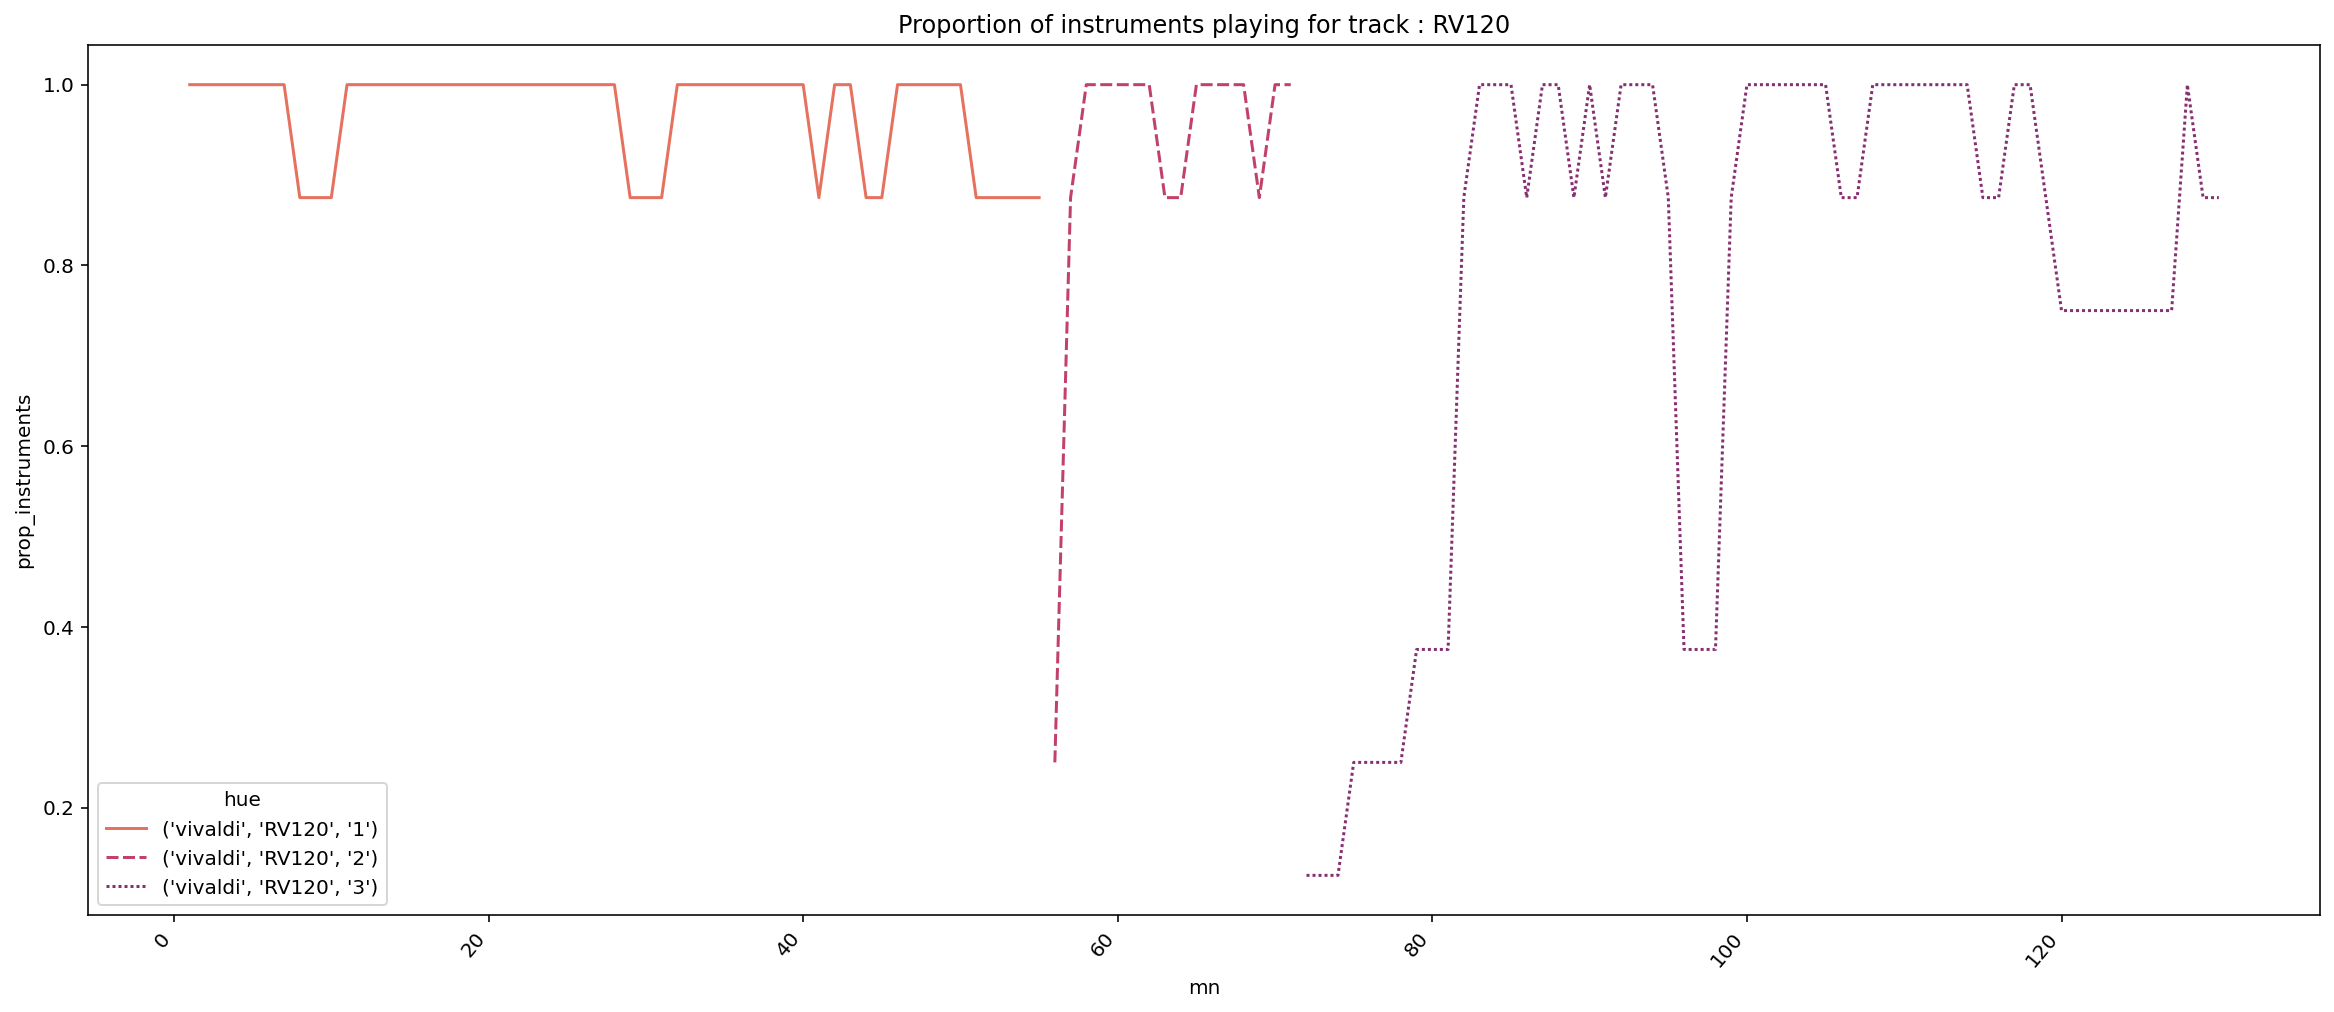

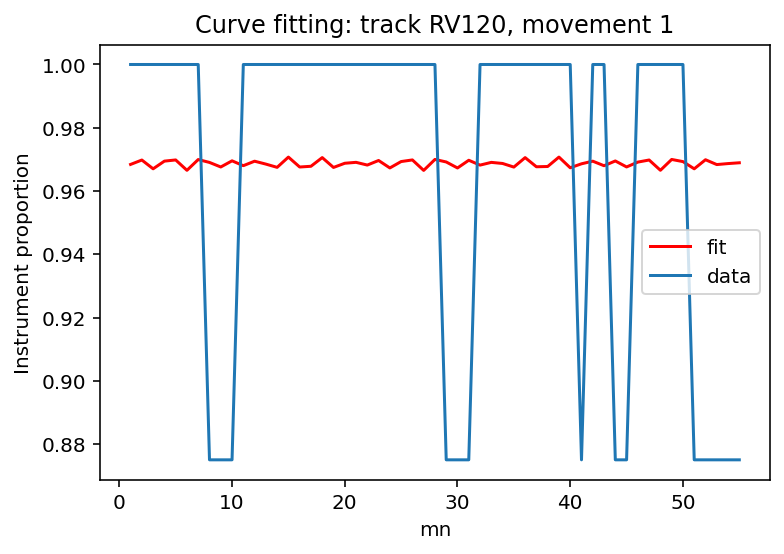

No discernable pattern in the proportion of instruments playing at each measure


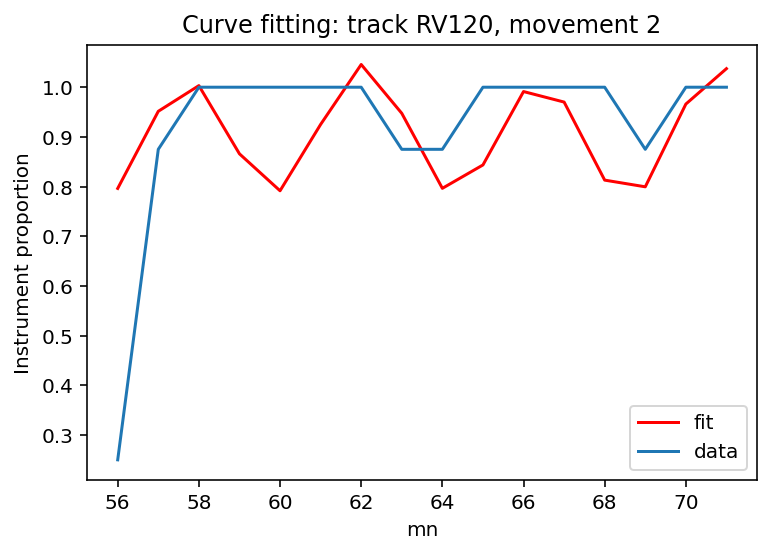

There seems to be a pattern in the proportion of instruments playing at each measure


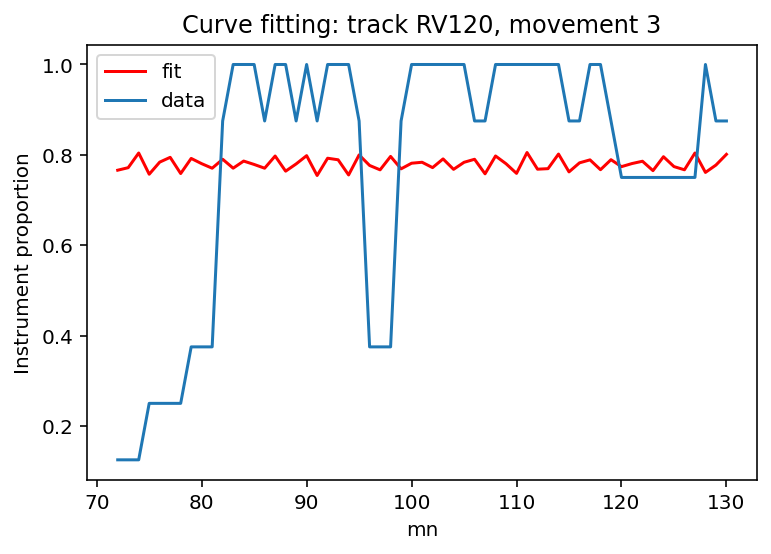

No discernable pattern in the proportion of instruments playing at each measure


In [87]:
comp = "Vivaldi"
ids = "RV120"
track_full = tutti_solo_distr(comp.lower(), str(ids), True)
pattern, A = get_distr_freq(track_full, True)

After the assesment of a possible periodical pattern in the frequency of instruments playing for each movement, the resulting patterns of False/True for each piece are aggregated to see if the pieces may have a similar structure regarding this feature.

The proportion of movement containing a pattern is also calculated for each composer to assess whether these could be more preponderant in Vivaldi's works. 

<a id='patterns'></a>
### Rythmic and Pitch Patterns
_[Back to top](#top)_

A very important feature of music similarity is the repeating patterns that can be heard throughout the pieces. In this project, we decided to focus on pitch patterns that can be extracted from MIDI files. The idea for this pattern analysis is based on *Arc Diagrams: Visualizing Structure in Strings*, Wattenberg, which proposed a method to make arc diagrams from repeating patterns that is highly suited for musical pieces. 

As described in the paper, an arc diagram generalizes the classical musical ABAA notation by using a pattern-matching algorithm to find repeated substrings. The algorithm used to find these arcs relies on *maximal matching*. With this method, a pair of repeating patterns is constituted of the longest, identical, non-overlapping and consecutive pair of substrings. From this definition, a suffix tree if constructed to identify repeated regions, a region where a sequence is repeated multiple times consecutively. A suffix tree is a type of tree data structure containing all the suffixes of a given string and their position in it.

In this project, the repeating patterns are sequences of pitches and the arcs are used to assess the amount of repetition between pieces to get an idea of interpieces similarity relating to pitch pattern repetition. The patterns recognised by our method does not comprise only absolute patterns, the exact same sequence of pitches, but also relative patterns, where the relative difference in pitch height is recognised as a pattern.

First, the deviation between one note and the one before is calculated for all notes in a MIDI notes list and a list of relative pitches is made. From this list, a suffix tree is created and iterated over to find all repeating sequences. 

Then, the repeating regions are calculated from these sequences. In the final step, the repeating sequences are checked for essential matching pairing as per the definition from the paper and all repeated sequences and regions are stored in a dictionary containing their occurences.

In [88]:
# calculate the deviation between the note and the last one 

def check_and_sub_pitch(row, ref_notes, index, rolling=True):
    id_ = tuple(row[index])
    if rolling:
        current_note = ref_notes.at[id_, "midi"][0]
        ref_notes.at[id_, "midi"].pop(0)
    else:
        current_note = ref_notes.at[id_, "midi"]
    return row['midi'] - current_note

def filter_colums(df, columns, values):
    return reduce(lambda l, r: l & r, 
                  [df[col] == values[i] for i, col in enumerate(columns)])

def compute_relative_pitches(df, rolling=True):
    index=["composer", "id", "part_id", "staff"]
    #index=df.index.names
    df_notes = df.dropna(subset=["midi"])#.reset_index(drop=True)
    if rolling:
        ref_notes = pd.DataFrame(df_notes.groupby(by=index)["midi"].apply(utils.list_with_0))
    else:
        ref_notes = pd.DataFrame(columns=index+["midi"]).set_index(index)
        staffs = pd.DataFrame(df.groupby(by=index).groups.keys(), columns=index).set_index(index)
        for _, s in staffs.iterrows():
            first_note = df_notes[filter_colums(df_notes, index, s.name)]["midi"].iloc[0]
            ref_notes.loc[s.name] = first_note
    if len(df_notes):
        df_notes['rel_midi'] = df_notes.apply(lambda row: check_and_sub_pitch(row, ref_notes, index, rolling),
                                              axis=1)
    else:
        df_notes['rel_midi'] = []
    return df_notes.reset_index(drop=True)

In [89]:
# suffix tree implementation helper

def special_sequence(seq):
    if len(seq) > 2 and seq[0] == seq[-1]:
        pairwise = zip(seq[:-1], seq[1:])
        return any(map(lambda x: x[0]!=x[1], pairwise))
    return False

# finds all repeating sequences in a list of MIDI notes converted in a suffix tree and iterates over it to find all occurences.

def get_repetitions(l):
    tree = Tree({'': l})
    repeats = sorted(tree.maximal_repeats(), key=(lambda x: len(str(x[1]))))
    res = {}
    done = {}
    for id_, path in repeats:
        key = str(path)
        pattern = list(path)
        start = path.start
        tmp = False
        if special_sequence(pattern):
            occurences = utils.find(pattern, l)
            pairwise = zip(occurences[:-1], occurences[1:])
            if (any(map(lambda x: x[1]-x[0]<len(pattern), pairwise))):
                start += 1
                pattern = pattern[1:]
                key = " ".join([str(e) for e in pattern])
        if not start in done.keys():
            done[start] = pattern
        prev_pat = done[start]
        n, m = len(pattern), len(prev_pat)
        if (pattern == prev_pat or n % m or pattern != prev_pat * int(n / m)):
            res[key] = [Interval([i, i+n]) for i in utils.find(pattern, l)]
            for interval in res[key]:
                i = int(interval[0].inf)
                done[i] = pattern
    return res

# from the repetitions found with get_repetitions, finds all repeating regions

def get_repetition_regions(repetitions):
    rep_regions = {}
    for seq, seq_interval in repetitions.items():
        clustered = utils.make_interval(seq_interval)
        intervals = []
        for comp in clustered.components:
            l, r = comp[0]
            if r - l > len(utils.str_to_int_list(seq)):
                intervals.append(comp)
        if len(intervals):
            rep_regions[seq] = utils.make_interval(intervals)
    return rep_regions

In [90]:
# computes whether a pair of substrings is a maximal or essential matching pair

def get_region(i1, i2, region_fundamentals):
    for region in region_fundamentals.keys():
        if i1 in region and i2 in region:
            return region
    return None

def same_fundamental(i1, i2, l, region_fundamentals, is_delta, verbose=False):
    region = get_region(i1, i2, region_fundamentals)
    if not region:
        if verbose:
            print(f"Intervals {i1} and {i2} do not belong to the same region")
        return False
    #assert len(region) == 1, ""
    fundamental = region_fundamentals[region]
    s1 = utils.get_sublist(l, i1)
    s2 = utils.get_sublist(l, i2)
    if s1 == fundamental and s2 == fundamental:
        return i1[0].sup == i2[0].inf
    if utils.find(s1, fundamental) and utils.find(s2, fundamental):
        n = len(fundamental)
        v1 = (i1[0].inf - region[0].inf) // n
        v2 = (i2[0].inf - region[0].inf) // n
        return v1 == v2 or is_delta
    if verbose:
        print(f"Intervals {i1} and {i2} ")
    return False
        
def is_maximal_matching_pair(i1, i2, l, verbose=False):
    s1 = utils.get_sublist(l, i1)
    s2 = utils.get_sublist(l, i2)
    if not s1 == s2:
        if verbose:
            print(f"String {s1} != {s2}")
        return False
    if i2[0].inf - i1[0].sup < 0:
        if verbose:
            print(f"Strings are overlapping: {i1}, {i2}")
        return False
    start, end = utils.start_to_start(i1, i2)
    i3 = Interval([start, end])
    between = [i+start for i in utils.find(s1, utils.get_sublist(l, i3))]
    if between:
        if verbose:
            print(f"String '{s1}' found at positions {between}")
        return False
    return True

def is_essential_matching_pair(i1, i2, l, all_regions, region_fundamentals, is_delta, verbose=False):
    if (i1 == i2 or len(i1) != 1 or len(i2) != 1 or
        i1[0].inf > i2[0].inf):
        if verbose:
            print("No possible match")
        return False
    
    if (not (i1 in all_regions and i2 in all_regions)
        or same_fundamental(i1, i2, l, region_fundamentals, is_delta, verbose)):
        return is_maximal_matching_pair(i1, i2, l, verbose)
    if verbose:
        print(f"Intervals {i1}, {i2} not elligible")
    return False

In [91]:
# from a list of MIDI notes, finds repetition, calculates intervals and check for essential matching pairs
# return a dictionary of repeated sequences and their occurences

def get_patterns(l, rep_region_ratio=3, seq_rep_ratio=5, is_delta=False):
    repetitions = get_repetitions(l)
    repetition_regions = get_repetition_regions(repetitions)
    
    all_regions = utils.make_interval(repetition_regions.values())
    region_fundamentals = {region: utils.str_to_int_list(fundamental)
                           for fundamental, interval in repetition_regions.items() 
                           for region in interval.components}
    patterns_dict = {}
    for pattern, intervals in repetitions.items():
        for (i1, i2) in zip(intervals[:-1], intervals[1:]):
            if is_essential_matching_pair(i1, i2, l, all_regions, region_fundamentals, is_delta):
                pat_len = len(utils.str_to_int_list(pattern))
                reps = utils.make_interval(intervals)
                ratio = seq_rep_ratio
                if pattern in repetition_regions.keys():
                    region = repetition_regions[pattern]
                    reps = utils.without(reps, region)
                    if i1 in region and i2 in region:
                        reps = region
                        sub_region = [comp for comp in region.components if i1 in comp and i2 in comp]
                        if len(sub_region) == 1:
                            reps = sub_region[0]
                            ratio = rep_region_ratio
                if sum([utils.interval_length(comp) for comp in reps.components])*pat_len > ratio:
                    if not (pattern in patterns_dict.keys()):
                        patterns_dict[pattern] = i1
                    patterns_dict[pattern] |= i2
    for pattern, rep_region in repetition_regions.items():
        if len(rep_region) > 1:
            pat_len = len(utils.str_to_int_list(pattern))
            if sum([utils.interval_length(comp) for comp in rep_region.components])*pat_len > seq_rep_ratio:
                if not (pattern in patterns_dict.keys()):
                    patterns_dict[pattern] = rep_region
                patterns_dict[pattern] |= rep_region
    sorted_res = {k: patterns_dict[k] for k in sorted(patterns_dict, key=len, reverse=False)}
    return sorted_res

In [92]:
# calls get_patterns and formats everything in a DataFrame

def get_patterns_from(df, col='midi', rep_region_ratio=3, seq_rep_ratio=5):
    is_delta = col == 'rel_midi'
    index = df.index.names
    pat_cols = ['pattern', 'length', 'nb_occurences', 'occurences', 'is_rep_region']
    res_df = pd.DataFrame(columns=index + pat_cols)
    if not len(df):
        return res_df
    print(f"Total iterations: {len(df)}")
    #display(res_df)
    for i, row in tqdm(df.iterrows()):
        pats = utils.patterns_df(get_patterns(row[col], rep_region_ratio=rep_region_ratio,
                                              seq_rep_ratio=seq_rep_ratio))
        pats[index] = i
        #display(pats)
        res_df = pd.concat([res_df, pats], ignore_index=True)
    return res_df

In [ ]:
all_notes = all_tracks.dropna(subset=["midi"]).reset_index(drop=True)
all_notes['midi'] = all_notes['midi'].apply(int)

df = utils.compute_with_intermediate(all_notes, "all_notes.tsv", compute_relative_pitches)
all_track_note_lists = df.groupby(by=["composer", "id", "part_id", "staff"])[['midi', 'rel_midi']].aggregate(list)

In [ ]:
all_patterns = utils.compute_with_intermediate(all_track_note_lists, 'all_patterns.tsv',
                                               get_patterns_from, max_index_length=100)  
all_rel_patterns = utils.compute_with_intermediate(all_track_note_lists, 'all_rel_patterns.tsv', 
                                                   get_patterns_from, max_index_length=100, col='rel_midi')

<a id='results'></a>
## Results
_[Back to top](#top)_

<a id='key_an'></a>
### Keys and movements analysis
_[Back to top](#top)_

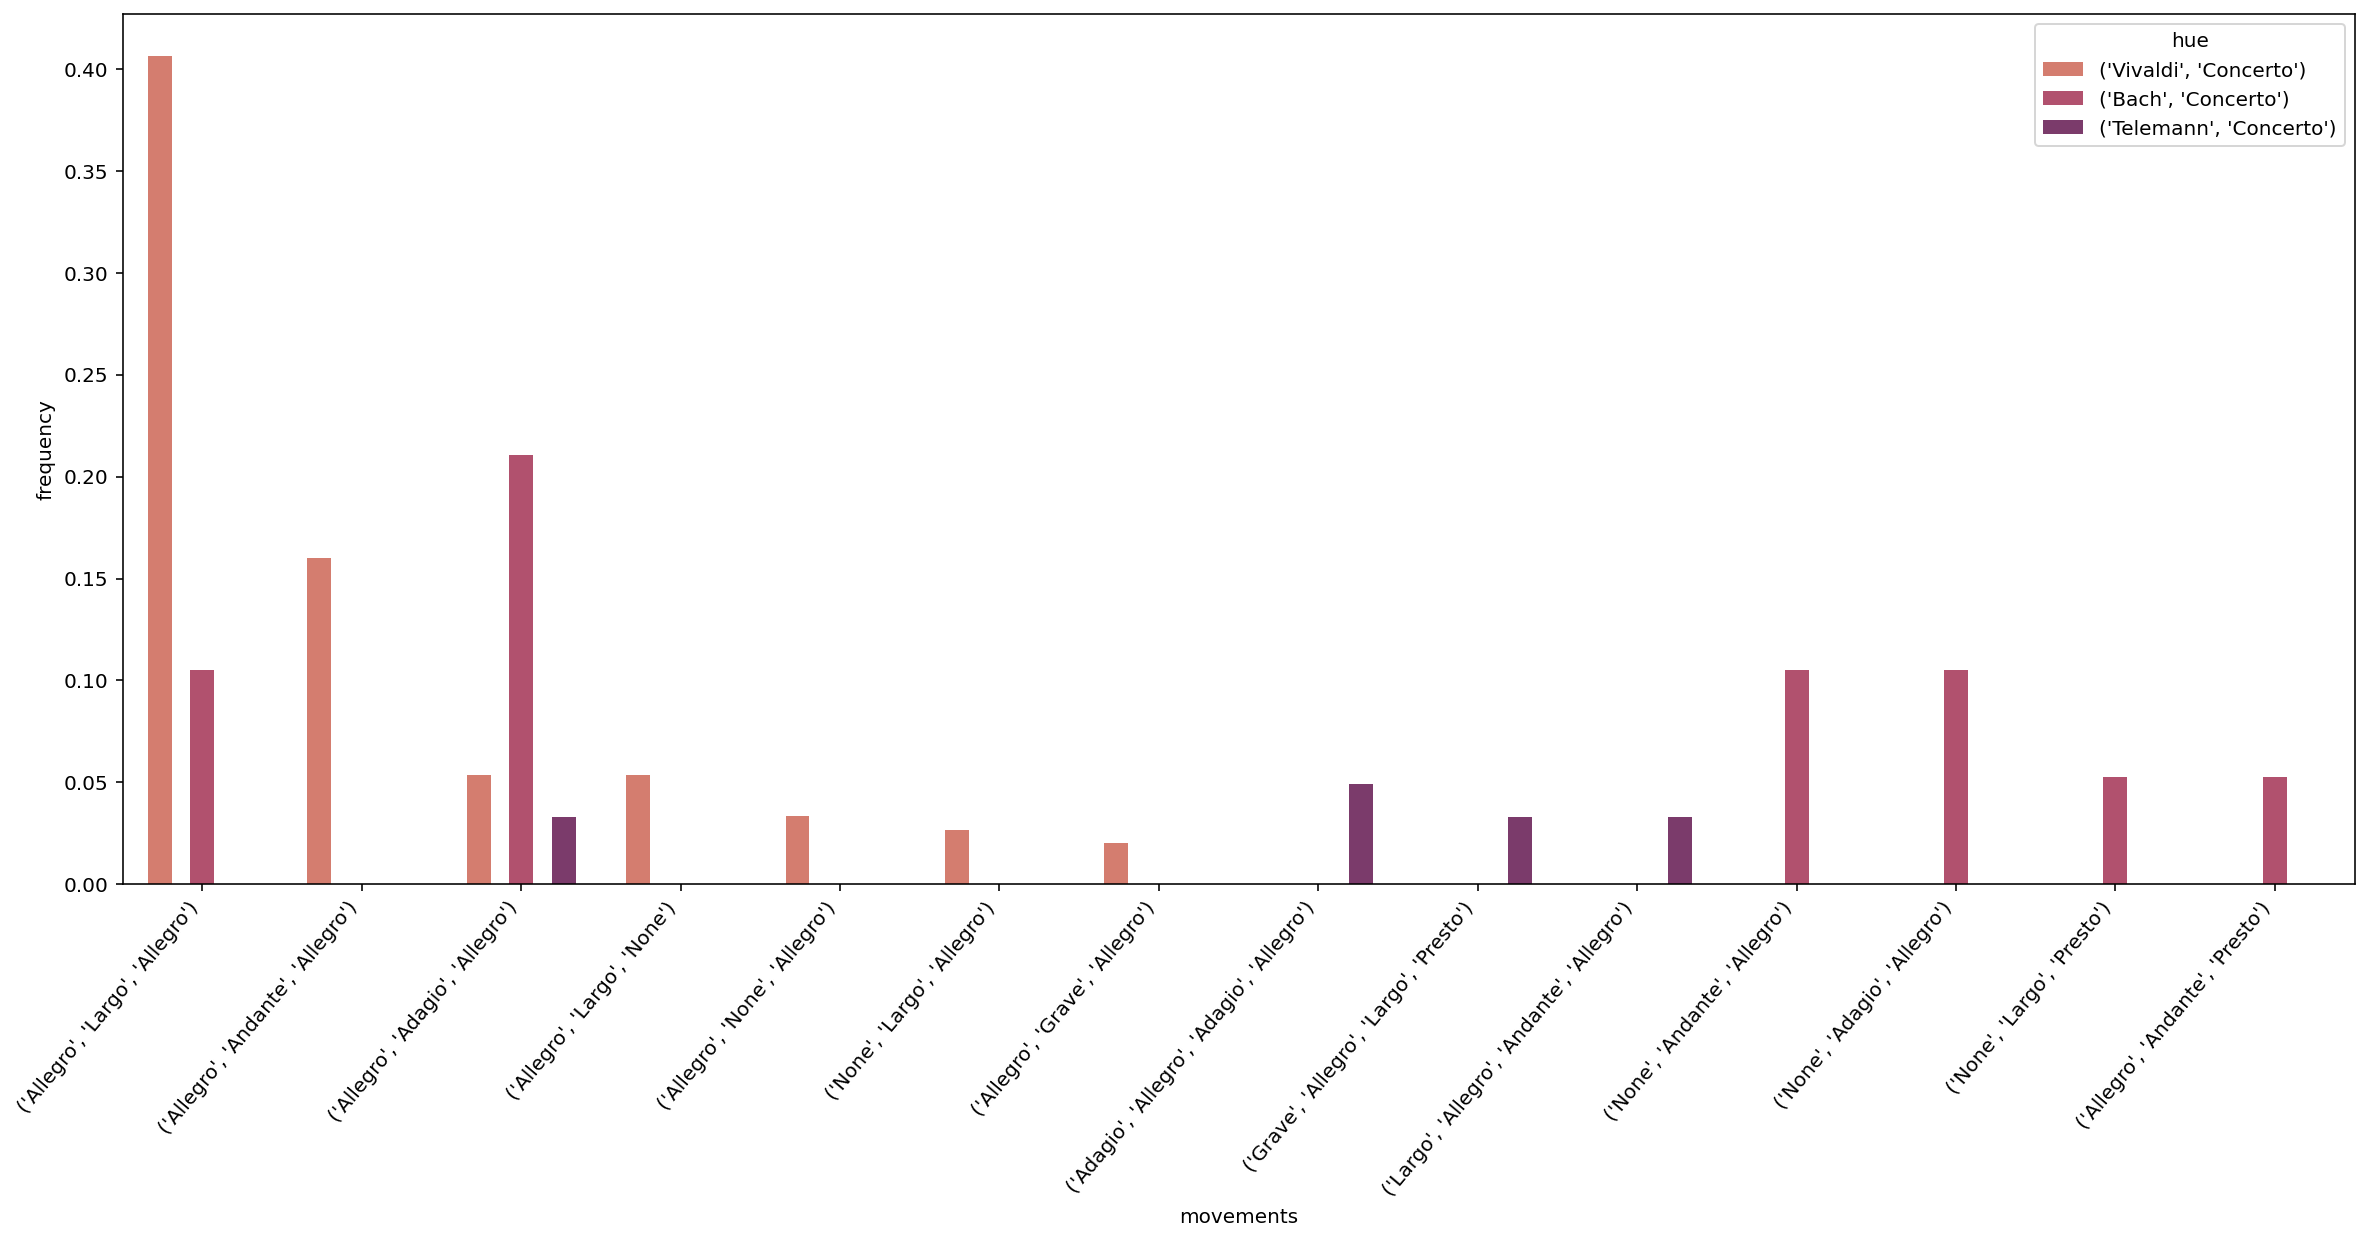

In [94]:
utils.plot_data(key_per_composer_and_type, "frequency", yaxis_boundary=0.02, xaxis_name=xaxis_name)

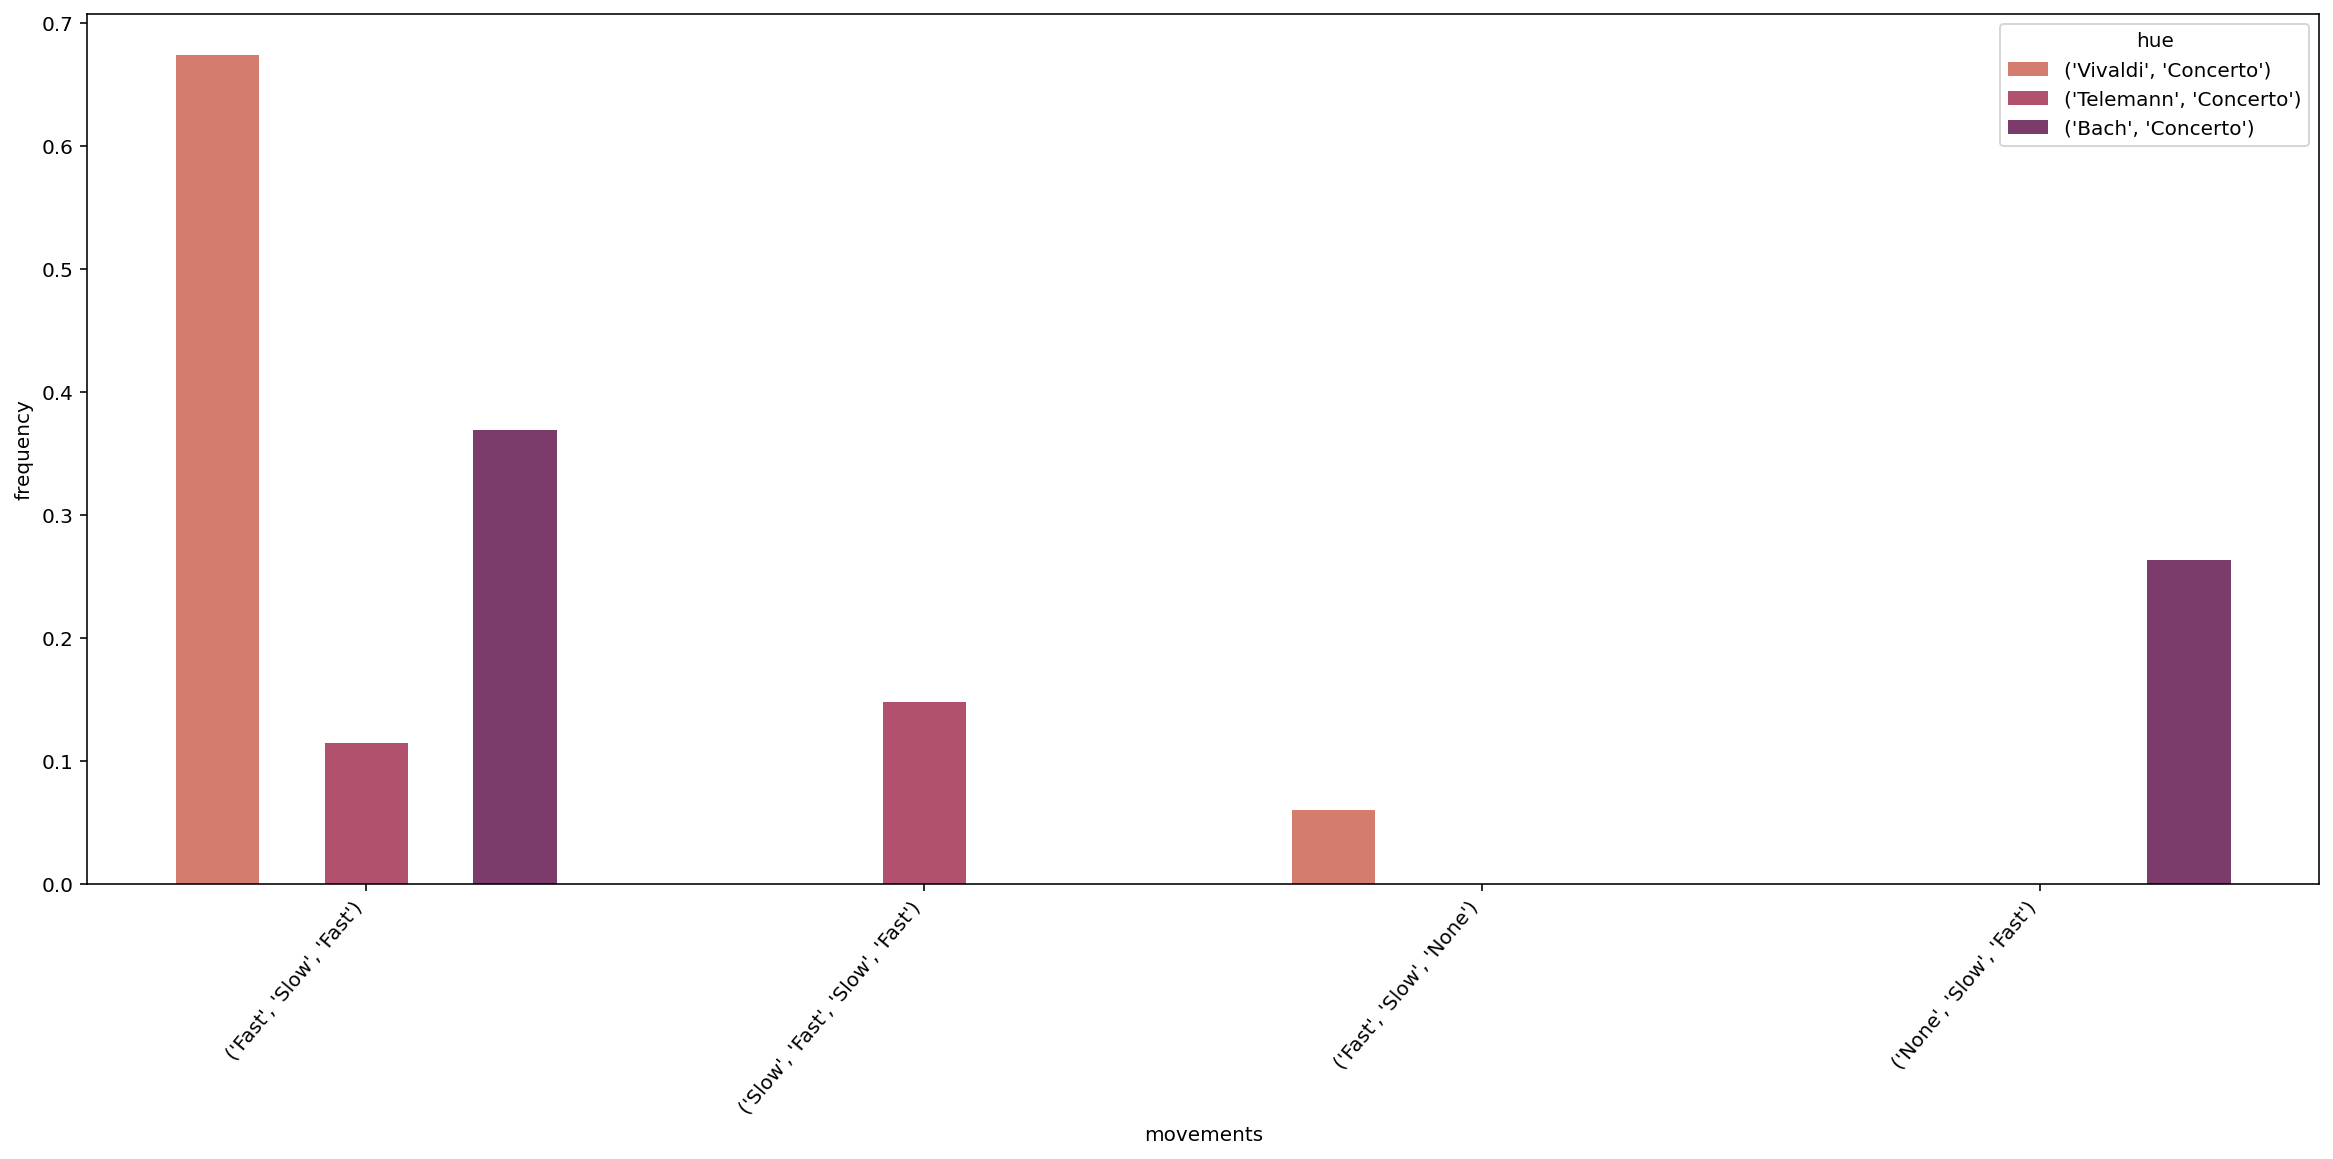

In [95]:
utils.plot_data(key_per_composer_and_type_reduced, "frequency", yaxis_boundary=0.04, xaxis_name=xaxis_name)

<a id='freq_an'></a>
### Frequency of instruments playing analysis
_[Back to top](#top)_

In [96]:
# for each piece of each composer and each musical type, calculate the distribution and check for patterns
prop_pattern = {}
pattern_all = {}
amplitude = {}
print("For each piece, check for pattern in each movement and aggregate per piece:")
for comp in metadata.composer.unique():
    if comp == "Vivaldi":
        for tp in metadata.type.unique():
            pattern = []
            ampl = []
            for ids in metadata[metadata.composer==comp][metadata.type == tp].id.unique():
                track_full = tutti_solo_distr(comp.lower(), str(ids))
                if not track_full is None:
                    if not get_distr_freq(track_full) is None :
                        pattern.append(get_distr_freq(track_full, False)[0])
                        ampl.append(get_distr_freq(track_full, False)[1])
            comp_ = comp + " " + tp
            print(comp_)
            pattern_all[comp_] = pattern
            amplitude[comp_] = np.mean(ampl)
            pattern_flat = list(itertools.chain(*pattern))
            s = pd.Series(pattern)
            print(s.value_counts())

            if len(pattern_flat) > 0:   
                prop_pattern[comp_] = list(pattern_flat).count(True)/len(pattern_flat)
    else:
        pattern = []
        for ids in metadata[metadata.composer==comp].id.unique():
            track_full = tutti_solo_distr(comp.lower(), str(ids))
            if not track_full is None:
                if not get_distr_freq(track_full) is None :
                    pattern.append(get_distr_freq(track_full, False)[0])
                    ampl.append(get_distr_freq(track_full, False)[1])
        pattern_all[comp] = pattern
        amplitude[comp] = np.mean(ampl)
        pattern_flat = list(itertools.chain(*pattern))
        print(comp)
        s = pd.Series(pattern)
        print(s.value_counts())

        if len(pattern_flat) > 0:   
            prop_pattern[comp] = list(pattern_flat).count(True)/len(pattern_flat)
 

For each piece, check for pattern in each movement and aggregate per piece:


C:\Users\evala\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\evala\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\evala\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\evala\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\evala\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\evala\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be rein

Vivaldi Concerto
[False, False, False]        8
[False, True, True]          3
[False]                      3
[True, False, False]         3
[True, False, True]          3
[False, False, True]         2
[False, True, False]         2
[True, True, False, True]    1
[True, True, False]          1
dtype: int64
Vivaldi Sonata
[False, False, False, False]    2
[True, False, False, False]     1
[False]                         1
dtype: int64
Telemann
[False, True, True, False]    1
[False, False, True]          1
dtype: int64
Bach
[False, False, True]     1
[False, False, False]    1
dtype: int64
Corelli
[False, False, False, False, False, False]    1
[False, False, False, False, False]           1
[False, False]                                1
dtype: int64


C:\Users\evala\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\evala\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [97]:
print("Mean amplitude of fitted curve per composer:")
print(amplitude)

Mean amplitude of fitted curve per composer:
{'Vivaldi Concerto': 0.02863240476496867, 'Vivaldi Sonata': 0.005164545437046949, 'Telemann': 0.008225892970773882, 'Bach': 0.008941286328737825, 'Corelli': 0.008120271353237889}


The first result shown is the mean amplitude of the curve fitted on each instrument playing frequency distribution per movement for each composer. We can clearly see that Telemann, Bach and Corelli have a value of 0.008 to 0.009 while Vivaldi's concerti have a mean amplitude that is three times as much, at 0.028. This could show a preponderance of periodic pattern in the playing instrument distribution which could lead to a feeling of repetitiveness from the listener.

Interestingly, this number is much lower in Vivaldi's sonatas, even lower that for the other composer's concerti, which could be a sign that it is not Vivaldi's overall style that may seem repetitive but only his concerti.

In [98]:
print("Proportion of movements with a distinctive sinusoïdal pattern for each composer and type: \n")
print(prop_pattern)

Proportion of movements with a distinctive sinusoïdal pattern for each composer and type: 

{'Vivaldi Concerto': 0.3287671232876712, 'Vivaldi Sonata': 0.07692307692307693, 'Telemann': 0.42857142857142855, 'Bach': 0.16666666666666666, 'Corelli': 0.0}


A first look at the results of the instruments frequency analysis show a higher proportion of movements with a sinusoïdal pattern in the instruments frequency for Vivaldi's concerti than for the other composer's or even Vivaldi's own sonatas.

We can see that this proportion is 0% for Corelli, only 16% for Bach wheras it is more than 30% for Vivaldi's concerti and even 43% for Telemann.

Another interesting result is that looking at other type of Vivaldi's work, the sonatas, we can see that the proportion is much lower, at below 8%. This could be an indication that the patterns are especially visible in Vivaldi's concerti and could signal a higher similarity between them as the others. 

All in all, we can see that we found a higher proportion of patterns in the instrument frequency distribution in Vivaldi's concerti compared to the other pieces analysed. This result is not overwhelmingly apparent, but combined with other factors, it could lead to an impression of similarity between Vivaldi's concerti.

<a id='pattern_an'></a>
### Repeating patterns analysis
_[Back to top](#top)_

To asses the repetitiveness in notes patterns through our corpus, we can first look at a number of features across the entire dataset, such as average pattern length and average number of occurences per pattern. These features are calculated as means over all repetitions calculated with the arc diagram method aggregeted at different levels, staff, part, piece and composer.

_Note_ : this part of the code does not run on Windows so the tables are copied from another notebook

In [ ]:
#my_patterns = utils.load_intermediate_df('all_patterns.tsv', corpus_root)
my_patterns = all_rel_patterns.copy()
patterns = my_patterns[(~my_patterns.is_rep_region) & (my_patterns.length > 1)].dropna().reset_index(drop=True)
conversion_dict = {'composer': str, 'id': str, 'part_id': str, 'staff': int,
                   'pattern': str, 'length': int, 'nb_occurences': int,
                   'occurences': utils.str_to_interval, 'is_rep_region': bool}
for col, f in conversion_dict.items():
    patterns[col] = patterns[col].apply(f)

def aggreg_results(df, by, all_notes=all_notes):
    patterns = df.copy()
    pattern_aggreg = lambda x: len(set(x))
    occurences_aggreg = lambda x: sum([utils.interval_length(comp) for comp in
                                       reduce(lambda a, b: a | b, list(x)).components])
    aggregation_method = {'pattern': pattern_aggreg, 'length': 'mean',
                          'nb_occurences': 'mean', 'occurences': occurences_aggreg}
    if by != ["composer", "id", "part_id", "staff"]:
        patterns = patterns.groupby(by=["composer", "id", "part_id", "staff"]).aggregate(
            {'pattern': lambda x: list(set(x)), 'length': list,
             'nb_occurences': list, 'occurences': occurences_aggreg}
        ).reset_index()
        #display(patterns)
        agg_lists = lambda x: reduce(lambda a, b: a + b, list(x))
        pattern_aggreg = lambda x: len(set(agg_lists(x)))
        lists_mean = lambda x: sum(agg_lists(x))/len(agg_lists(x))
        aggregation_method = {'pattern': pattern_aggreg, 'length': lists_mean,
                              'nb_occurences': lists_mean, 'occurences': sum}
    aggreg = patterns.groupby(by=by).aggregate(aggregation_method).rename(
        columns={'pattern': 'nb_unique_patterns', 'length': 'avg_pat_length',
                 'nb_occurences': 'avg_nb_occurences', 'occurences': 'total_events_in_patterns'})
    #aggreg.insert(1, 'nb_patterns', aggreg['pattern'].apply(len))
    tmp = all_notes[~utils.get_missing(all_notes, aggreg.reset_index(), index=by)]
    aggreg['total_events'] = tmp.groupby(by=by)['midi'].aggregate('count')
    return aggreg
index = ["composer", "id", "part_id", "staff"]
for i in range(4, 0, -1):
    aggreg = aggreg_results(patterns, by=index[:i])
    display(aggreg)
    print("Column means:")
    display(aggreg.apply('mean'))
print("=====================")
aggreg = aggreg_results(patterns, by=index[:2]+index[3:])
display(aggreg)
print("Column means:")
display(aggreg.apply('mean'))

### Aggregated per:

### Staff

|Feature|Mean|
|:---|:---:|
|nb unique patterns|58.236295|
|avg pattern length|5.629769|
|avg nb occurences|4.806214|
|total events in patterns|329.226843|
|total events|350.372401|

### Part

|Feature|Mean|
|:---|:---:|
|nb unique patterns|224.978836|
|avg pattern length|5.811303|
|avg nb occurences|5.308323|
|total events in patterns|1842.973545|
|total events|1962.952381|

### Piece

|Feature|Mean|
|:---|:---:|
|nb unique patterns|544.166667|
|avg pattern length| 5.761367|
|avg nb occurences|5.468174|
|total events in patterns|5277.606061|
|total events|5621.181818|


### Composer

|Feature|Mean|
|:---|:---:|
|nb unique patterns|4721.750000|
|avg pattern length| 5.671220|
|avg nb occurences|5.576348|
|total events in patterns|87080.500000|
|total events|92749.500000|


### Staff - aligned per movement

|Feature|Mean|
|:---|:---:|
|nb unique patterns|132.501217|
|avg pattern length| 5.673224|
|avg nb occurences|5.049994|
|total events in patterns|847.498783|
|total events|902.605839|


In [99]:
avg_pat_length = [5.629769, 5.811303, 5.761367, 5.671220, 5.673224]
print("Mean average pattern length over levels of aggregation: " + str(np.mean(avg_pat_length)))
print("Standard deviation: " + str(np.std(avg_pat_length)))

Mean average pattern length over levels of aggregation: 5.7093766
Standard deviation: 0.06662176715939015


In [100]:
avg_nb_occurences = [4.806214, 5.308323, 5.468174, 5.576348, 5.049994]
print("Mean number of occurences per pattern over levels of aggregation: " + str(np.mean(avg_nb_occurences)))
print("Standard deviation: " + str(np.std(avg_nb_occurences)))

Mean number of occurences per pattern over levels of aggregation: 5.241810599999999
Standard deviation: 0.28075525504581406


A general look at the occurences and length of patterns found in all pieces already tells us that the level of aggregation does not make the average length of pattern change significantly. The average length is around 5.7 notes with standard deviation of 0.067.

The average number of occurences per pattern is less stable, at an average of 5.24 occurences with standard deviation of 0.28. We can see that this number is lower per staff, which already tells us that repetition can be found slightly more predominantly inbetween parts or pieces than in staffs.

The next step in the analysis of pattern repetition is to look at differences in repeated patterns features between composer. The features shown in the table below are the same as those examined in the previous part; average pattern length, average number of occurences per pattern, total events in patterns, total envents and the number of unique patterns. 

In [ ]:
pats = patterns.copy().reset_index(drop=True)
cols = []
for i in range(4, 1, -1):
    sub = index[1:i]
    truc = ", ".join(sub)
    pats[truc] = list(zip(*[pats[col] for col in sub]))
    cols.append(truc)
n = len(all_track_note_lists)
tmp = pats.groupby(by=['composer', 'pattern'])[cols].aggregate(lambda x: len(set(x)))
display(tmp)
tmp.reset_index().groupby(by='composer').aggregate('mean')

|composer|nb_unique_patterns|avg_pat_length|avg_nb_occurences|total_events_in_patterns|total_events|
|:-|:-:|:-:|:-:|:-:|:-:|
|**bach**|3192|5.493924|6.163924|37920.0|39456|
|**corelli**|667|6.644599|5.587979|8594.0|9129|
|**telemann**|1623|4.852368|5.079737|18535.0|19845|
|**vivaldi**|13405|5.693988|5.473752|283273.0|302568|

In [101]:
print("Number of unique patterns divided by the total number of events")
print("Vivaldi: " +str(13405/302568))
print("Bach: " +str(3192/39456))
print("Telemann: " +str(1623/19845))
print("Corelli: " +str(667/9129))

Number of unique patterns divided by the total number of events
Vivaldi: 0.04430409032019249
Bach: 0.08090024330900243
Telemann: 0.08178382464096749
Corelli: 0.07306386241647497


A quick look at the table tells us that the number are all higher for Vivaldi's work than for the other composers. The total number of events is obviously linked to the amount of data analysed and a similar proportionality with the number of unique patterns between composers could indicate a similar level of variety in the repeating patterns. However, looking at the proportion of unique pattern to the total number of events, we can already see that Vivaldi's pattern variety is much lower that for the other composers. Indeed, while Bach and Telemann have a proportion around 0.8 and Corelli a slightly lower proportion of 0.73, Vivaldi's is at 0.44. almost half of the other's. This could already be a sign of less variety in repeting pattern in Vivaldi's work and be translated to a feeling of repetitiveness. 

The average pattern length does not give us much information about similarity between pieces of the same composer, though it is interesting to note that this number is higher for Corelli, meaning longer pattern repeated and lower for Telemann, while it is similar for Vivaldi and Bach. 

In contrast, the average number of occurences per pattern can give us an insight in the repetitiveness of a composer's work, with a higher number meaning that patterns are repeated more times across the pieces. This number is the lowest for Telemann, which tells us that he did not reuse patterns as much in his concerti and highest for Bach. Corelli and Vivaldi have similar values, which lie around the average of the two extremes.

This result is very interesting as it contradicts the first assessment of variety in patterns shown above. Thus, while Vivaldi may have much less diversity in the repeating patterns, they do not repeat over his corpus as much as for Telemann. This result could be explained by a higher standard deviation in average number of occurences or outliers.

The last analysis done on the repeated patterns is a general count of the number of staffs, movements and pieces using a certain pattern. A general look at the table tell us that most patterns are used only once and only some are reused many times, making it similar to a power law. 

When these counts are aggregated by composer and the mean is taken, we get the table below. 

|composer|# staffs|# movements|# pieces|
|:-|:-:|:-:|:-:|
|**bach**|2.474937|1.417293|1.185464|
|**corelli**|1.721139|1.544228|1.215892|
|**telemann**|2.341343|1.508934|1.404190|
|**vivaldi**|3.637896|2.575009|2.166430|
	

We can see that Vivaldi's numbers are higher than the rest of the composers. However, these numbers aren't normalized by the amount of pieces and movements analysed per composer, so Vivaldi's higher numbers could be explained by the amount of data used. 

Even without normalization, these results can already tell us something about the way patterns are repeated in a composer's work. Indeed, we can see that repetitions are much more common in staffs, whereas, repetition across pieces is rarer. The decrease from repetition in staffs to movements and to pieces seem proportional for each composer with the only notable outlier being Bach with more reuse of pattern inside staffs.

In [102]:
vivaldi_repetition =  {"staff": 3.637896, "movement":2.575009, "piece": 2.166430}
corelli_repetition =  {"staff": 1.721139, "movement":1.544228, "piece": 1.215892}
telemann_repetition =  {"staff": 2.341343, "movement":1.508934, "piece": 1.404190}
bach_repetition =  {"staff": 2.474937, "movement":1.417293, "piece": 1.185464}

repetition = {"vivaldi": vivaldi_repetition,"telemann":telemann_repetition, "bach": bach_repetition , "corelli": corelli_repetition}

In [103]:
import math
df_rep = pd.DataFrame(columns = ['composer','# staffs','# movements','# pieces'])
for comp in metadata.composer.unique():
    nb_pieces = 0
    nb_mvmt = 0
    nb_staffs = 0
    for ids in metadata[metadata.composer==comp].id.unique():  
        if type(ids) == str:
            ids = ids.replace(":", "-")
            track = load_track_df(comp.lower(), ids)
            if track is not None:
                nb_pieces += 1
                nb_mvmt += len(track.part_id.unique())
                for mvmnt in track.part_id.unique():  
                    nb_staffs += len(track[track.part_id == mvmnt].staff.unique())
    df_rep = df_rep.append({"composer":comp , 
                        "# staffs": nb_staffs,
                        '# movements':nb_mvmt,
                        '# pieces': nb_pieces}, 
                        ignore_index=True)   
    df_rep = df_rep.append({"composer":comp+ " normalized", 
                            "# staffs": repetition[comp.lower()]["staff"]/nb_staffs,
                            '# movements': repetition[comp.lower()]["movement"]/nb_mvmt,
                            '# pieces': repetition[comp.lower()]["piece"]/nb_pieces}, 
                            ignore_index=True)


In [104]:
df_rep.set_index("composer")

# staffs # movements  # pieces
composer                                           
Vivaldi                   561          86        30
Vivaldi normalized   0.006485    0.029942  0.072214
Telemann                   44           7         2
Telemann normalized  0.053212    0.215562  0.702095
Bach                       58           6         2
Bach normalized      0.042671    0.236215  0.592732
Corelli                    37          13         3
Corelli normalized   0.046517    0.118787  0.405297

Looking at the normalized counts of staffs, movements and pieces where patterns are repeated, we can see that patterns are actually reused more across pieces and movements than inside staffs, which makes sense as they are much smaller parts. However, these numbers are much lower for Vivaldi, which could signal an overwhealming amount of patterns only seen once. 

<a id='conclusion'></a>
## Conclusion
_[Back to top](#top)_

Looking at all the results combined, we can not readily assume a more stricking similarity between Vivaldi's concerti compared to Bach's, Corelli's or Telemann's. 

There is some evidence of less pattern variety in Vivaldi's work, which could be interpretated as more similarity. However, our results could be biased by the amount of data used for the analysis of each composer, as only 2 or 3 concerti were analyzed for the other composers compared to 30 pieces for Vivaldi. Indeed, with 2 or 3 concerti, it could be a simple coincidence that, for example the mean length of patterns found in Corelli's pieces is higher.

In conclusion, while there is some evidence of repetivity in Vivaldi's work, it would be an overstatement to say that it could lead to the declaration that he "wrote 500 times the same concerto". It would be interesting to redo the analysis with more data and see if the results hold for more pieces or if the lesser amount of variety in Vivaldi's work is due to the amount of pieces analyzed.